# **College Student Placement Factors Dataset** #

#### Credits to `SAHIL ISLAM007` for the dataset. ####

Source: https://www.kaggle.com/datasets/sahilislam007/college-student-placement-factors-dataset?resource=download


# Table of Contents #
1. [Libraries](#1-libraries)
2. [Data Pre-Processing](#2-data-pre-processing)<br>
&emsp; 2.1 [Dataset](#21---dataset)<br>
&emsp;&emsp;&emsp; 2.1.1 [Known Fields](#211---known-fields)<br>
&emsp;&emsp;&emsp; 2.1.2 [Aims & Objectives](#212---aims--objectives)<br>
&emsp; 2.2 [Cleaning the Dataset](#22---cleaning-the-dataset)<br>
&emsp;&emsp;&emsp; 2.2.1 [Known Fields](#221---outlier-detection-w-z-score)<br>
&emsp;&emsp;&emsp; 2.2.2 [Replace Outliers](#222---replace-outliers)<br>
&emsp;&emsp;&emsp; 2.2.3 [Boolean-to-Binary](#223---convert-boolean-to-binary)<br>
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)<br>
&emsp; 3.1 [Correlation Matrix](#31---correlation-matrix)<br>
&emsp; 3.2 [Factor Analysis](#32---factor-analysis)<br>
&emsp;&emsp;&emsp; 3.2.1 [KMO Scores](#321---kmo-scores)<br>
&emsp;&emsp;&emsp; 3.2.2 [Eigen Values](#322---eigen-values)<br>
&emsp;&emsp;&emsp; 3.2.3 [Conclusion for Factor Analysis](#323---conlusion-for-factor-analysis)<br>
&emsp; 3.3 [Principal Component Analysis](#33---principal-component-analysis)<br>
&emsp;&emsp;&emsp; 3.3.1 [Re-run PCA](#331---re-run-pca-dimensionality-reduction)<br>
&emsp; 3.4 [Random Forest](#34---randomforest)<br>
&emsp;&emsp;&emsp; 3.4.1 [Validating the Model](#341---validating-the-model)<br>
&emsp;&emsp;&emsp; 3.4.2 [Retest Without Internship Experience](#342---forest-model-without-internship_experience)<br>
4. [Feature Engineering](#4-feature-engineering)<br>
&emsp; 4.1 [Initial Formula](#41---initial-formula)<br>
&emsp;&emsp;&emsp; 4.1.1 [Plot the Distribution](#411---plot-the-distribution)<br>
&emsp; 4.2 [Determining Critical Threshold for Placements](#42---determining-critical-threshold-for-placements)<br>
&emsp;&emsp;&emsp; 4.2.1 [Random Forest](#421---randomforest)<br>
&emsp;&emsp;&emsp; 4.2.2 [Logistic Regression](#422---logistic-regression)<br>
5. [College Segmentation](#5-college-segmentation)<br>
&emsp; 5.1 [KMeans Clustering](#51---k-means-clustering)<br>
&emsp;&emsp;&emsp; 5.1.1 [KMeans Retest w/ 3 Clusters](#511---kmeans-retest-w-3-clusters)<br>
&emsp; 5.2 [Gaussian Mixture Model](#52---gaussian-mixture-model)<br>
&emsp; 5.3 [DBSCAN](#53---dbscan)<br>
&emsp;&emsp;&emsp; 5.3.1 [Calculating Parameters](#531---calculating-parameters)<br>
&emsp;&emsp;&emsp; 5.3.2 [DBSCAN Retest w/ Hyperparameter Tuning](#532---dbscan-retest-w-hyperparameter-tuning)<br>
&emsp; 5.4 [Hierarchical Clustering](#54---hierarchical-clustering)<br>
&emsp;&emsp;&emsp; 5.4.1 [Hierarchical Clustering w/ 4 Clusters](#541---hierarchical-clustering-w-4-clusters)<br>
&emsp; 5.5 [Evaluating Clustering Models](#55---evaluating-clustering-models)<br>
&emsp; 5.6 [Assigning Segments](#56---assigning-segments)<br>
6. [Application of Segments](#6---application-of-segments)<br>
&emsp; 6.1 [Refining the Student Score Formula by Segments](#61---refining-the-student-score-formula-by-segments)<br>

## 1. **Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import zscore, pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
from factor_analyzer.factor_analyzer import calculate_kmo, FactorAnalyzer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, silhouette_score, silhouette_samples
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture 
from sklearn import metrics
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. **Data Pre-Processing**

### 2.1 - Dataset

In [ ]:
path = r'Insert data path here'
data = pd.read_csv(path)

In [ ]:
print(data.info())

#print(data.describe())

#print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB
None


#### 2.1.1 - Known Fields
- **College_ID**
    - Unique ID of colleges.
- **IQ**
    - Student IQ score (normally distributed around 100.)
- **Prev_Sem_Result**
    -  Grade point average of previous semester (range of 5.0 to 10.0).
- **CGPA**
    - Cumulative Grde Point Average  (range of ~5.0 to 10.0)
- **Academic_Performance**
    - Scale (1 to 10) for annual academic rating.
- **Internship_Experience**
    - Boolean ('Yes'/'No') for student past internship experience.
- **Extra_Curricular_Score**
    - Scale (1 to 10) for involvement in extracurriculars.
- **Communication_Skills**
    - Scale (1 to 10) for communication ability rating.
- **Projects_Completed**
    - Count (0 to 5) of projects completed.
- **Placement**
    - Boolean ('Yes'/'No') of whether student got a placement.

#### 2.1.2 - Aims & Objectives
- Clean/normalize/adjust dataset for data analysis if needed.
- Identify preliminary (linear) relationships between data using a correlation matrix with p-values for significance.
- Identify key factors and their importance that influence placement using factor analysis (or other) methods.
- Consider feature engineer a ``Student_Score`` using factors (and weightings if needed) for determining placement.
- Test ``Student_Score`` for suitability using a decision tree.
- If suitable, identify key thresholds that can be used for automating placement decisions using ``Student_Score``. Consider methods such as logistic regression or random forest.
- Train a model to categorise whether a student will get a placement or not. Consider ensemble learning methods for improved accuracy.
- Test the model for suitability.

### 2.2 - Cleaning the Dataset

In [ ]:
empty_columns = data.columns[data.isnull().any()].to_list()
print("Columns with empty values: ", empty_columns)

Columns with empty values:  []


In [ ]:
dupes = data[data.duplicated()]
print("Duplicate values: ", dupes.shape[0])

Duplicate values:  0


#### 2.2.1 - Outlier Detection w/ z-Score
Outliers should only be possible in quantitative fields.

In [ ]:
 #Possible fields: 'IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Projects_Completed'

#Parameters
outlier_std = 3         #Default is 3.
quantitative_fields = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']


#### Note: ####
Function `find_outliers` will re-define z-scores when called. <br>
Therefore updating the dataset AND calling the function after, can cause new outliers to re-emerge based on updated dataset.

In [ ]:
#Return relevant outlier values.
def find_outliers(param_field):
    data_z = pd.DataFrame(zscore(data[param_field], nan_policy='omit'), columns=[param_field], index=data.index)
    outlier_mask = (abs(data_z) > outlier_std).any(axis=1)
    outliers = data[outlier_mask]
    
    return outlier_mask, outliers
    
mask, outliers = find_outliers(quantitative_fields)

print(outliers)

     College_ID   IQ  Prev_Sem_Result  CGPA  Academic_Performance  \
209     CLG0073  157             8.33  8.53                     4   
262     CLG0004   51             7.26  7.43                     1   
478     CLG0047  146             9.72  9.44                     8   
1615    CLG0037  147             8.34  7.90                     6   
1957    CLG0037  147             7.58  7.14                     4   
2024    CLG0044   54             9.04  8.82                     4   
2305    CLG0047  146             5.81  5.37                     8   
2895    CLG0056  158             6.07  5.89                     8   
3716    CLG0033  148             9.37  9.08                     1   
3982    CLG0037  147             5.15  5.32                     9   
4198    CLG0071   54             9.07  9.27                     7   
4725    CLG0017   52             8.92  9.36                     8   
4779    CLG0057   52             7.56  7.36                     9   
4870    CLG0100  146             9

In [ ]:
#Determine which columns have outliers above the specified standard deviation, and how many.
for field in quantitative_fields:
    _ , outliers = find_outliers(field)
    print(f"Number of outliers in {field}: {outliers.shape[0]}")

Number of outliers in IQ: 28
Number of outliers in Prev_Sem_Result: 0
Number of outliers in CGPA: 0
Number of outliers in Academic_Performance: 0
Number of outliers in Extra_Curricular_Score: 0
Number of outliers in Communication_Skills: 0
Number of outliers in Projects_Completed: 0


#### 2.2.2 - Replace Outliers

In [ ]:
IQ_median = data['IQ'].median()
print("Median of IQ: ", IQ_median, '\n')

IQ_outlier_mask, _ = find_outliers(['IQ'])
IQ_outlier_indices = data[IQ_outlier_mask].index.tolist()

#Replace outliers of IQ values with median.
data.loc[IQ_outlier_mask, 'IQ'] = IQ_median

#Check that the outlier values have been replaced with median (99 in this case), using indexes from mask.
print("Replaced values:\n", data.loc[IQ_outlier_indices, 'IQ'])


Median of IQ:  99.0 

Replaced values:
 209     99
262     99
478     99
1615    99
1957    99
2024    99
2305    99
2895    99
3716    99
3982    99
4198    99
4725    99
4779    99
4870    99
4997    99
5796    99
6891    99
7140    99
7223    99
7305    99
7611    99
7677    99
8024    99
8180    99
8200    99
8248    99
8726    99
9770    99
Name: IQ, dtype: int64


#### 2.2.3 - Convert Boolean to Binary
Cast Yes/No values to 1/0. <br>
Initial data type is object so it needs to be cast into a string.

In [ ]:
data['Internship_Experience'] = data['Internship_Experience'].astype(str)
data['Placement'] = data['Placement'].astype(str)

data['Internship_Experience'] = data['Internship_Experience'].map({'No' : 0, 'Yes' : 1})
data['Placement'] = data['Placement'].map({'No' : 0, 'Yes' : 1})

#print(data['Internship_Experience'])
#print(data['Placement'])

## 3. **Exploratory Data Analysis**

### 3.1 - Correlation Matrix
Checking linear relationships between numerical data.

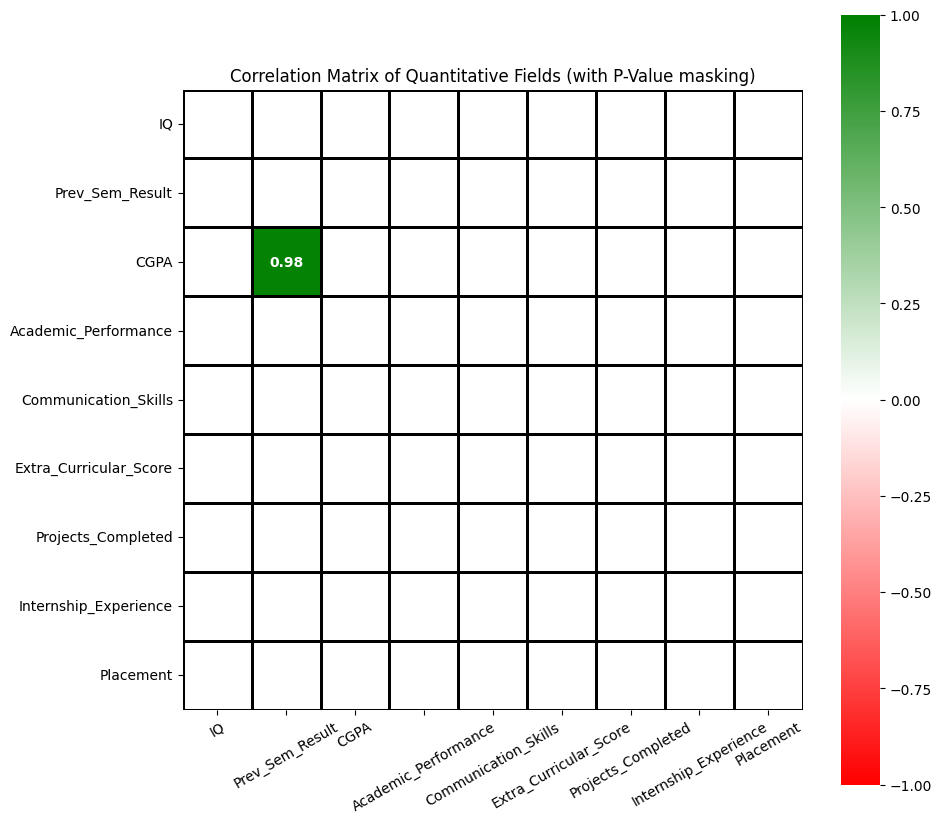

In [ ]:
#Base parameters
quantitative_fields = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Extra_Curricular_Score', 'Projects_Completed', 'Internship_Experience', 'Placement'] #Append new binary values.
corr_data = data[quantitative_fields].corr()
p_value_corr = round(corr_data.corr(method=lambda x, y : pearsonr(x, y)[1]), 4)
p_value = 0.05 #Default p-value for significance = 0.05

#Figure parameters
mask = np.triu(corr_data)
p_mask = np.invert(np.tril(p_value_corr < p_value))
gradient = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
x, fig = plt.subplots(figsize=(10,10))

#Switch mask between p_value filtering depending on preference.
sns.heatmap(corr_data, mask=p_mask, cmap=gradient, vmin=-1, vmax=1, linewidths=2, linecolor='black', annot=True, annot_kws={'fontweight' : 'bold'}, square=True)
plt.title('Correlation Matrix of Quantitative Fields (with P-Value masking)')
plt.xticks(rotation=30)
plt.show()

## Student Score  ##
**Defined As**: A measure used to determine the likelihood a student will receive a placement based on their features/parameters. 
<br>
</br>
**Things to Consider**: 
- Identify features relevant to creating the ```Student Score```.
- Weighting of said features.
- Create a formula based on the above two points.
- Identifying a threshold for rejecting a student based on their score.
- Potentially adjust threshold based on the college, as different colleges may have different criterias.

### 3.2 - Factor Analysis
Based on correlation matrix, FA is unlikely to produce outstanding results. However, it is worth checking incase. <br>
**KMO Scores** will be used to test suitability of FA based on features.

#### 3.2.1 - KMO Scores

In [ ]:
#Parameters
fa_features = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Extra_Curricular_Score', 'Projects_Completed', 'Internship_Experience'] #Placement removed since Student_Score is used to determine this.
kmo_model = calculate_kmo(data[fa_features])
kmo_threshold = 0.5 #Minimum acceptable value for factor analysis (default is 0.5). Increase accordingly for better robustness.


#Is the KMO value in an acceptable range?
def kmo_result(param_index):
    if(kmo_model[0][param_index] > kmo_threshold):
        return 'Accept'
    else:
        return 'Reject'


#Check KMO score of each feature.
for x, feature in enumerate(fa_features):
    print(f'[{feature}] KMO Score: {kmo_model[0][x]:.4f} - Result: {kmo_result(x)}')

[IQ] KMO Score: 0.5013 - Result: Accept
[Prev_Sem_Result] KMO Score: 0.5001 - Result: Accept
[CGPA] KMO Score: 0.5001 - Result: Accept
[Academic_Performance] KMO Score: 0.4537 - Result: Reject
[Communication_Skills] KMO Score: 0.6134 - Result: Accept
[Extra_Curricular_Score] KMO Score: 0.4969 - Result: Reject
[Projects_Completed] KMO Score: 0.6011 - Result: Accept
[Internship_Experience] KMO Score: 0.5661 - Result: Accept


#### Breakdown of Results: ####
Excluding ```Academic_Performance``` & ```Extra_Curricular_Score```, all other features were in **acceptable** range. <br>
*However*, asides from  ```Communication_Skills``` & ```Projects_Completed``` (which were classified as mediocore), all other values were **miserable** (0.5 - 0.6 range). <br>
Consider trying an alternative method such as **PCA** or **Decision Tree**. <br>

#### 3.2.2 - Eigen Values
Further testing for Factor Analysis suitability.

Eigenvalues: 
Factor 0: 1.9828
Factor 1: 1.0479
Factor 2: 1.0229
Factor 3: 1.0067
Factor 4: 0.9794
Factor 5: 0.9740
Factor 6: 0.9671
Factor 7: 0.0192


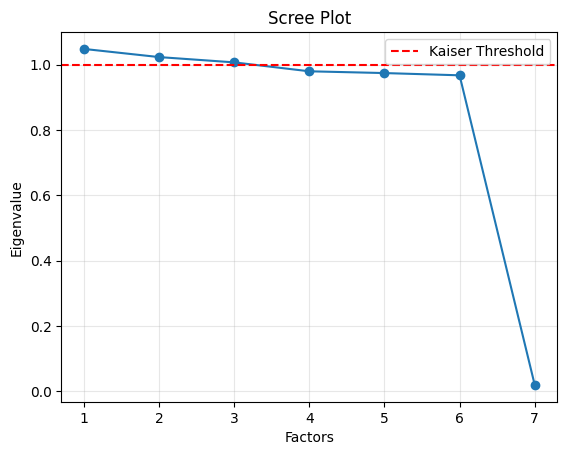

In [ ]:
fa_model = FactorAnalyzer(rotation='varimax')
fa_model.fit(data[fa_features])

eigen_values, v = fa_model.get_eigenvalues()
kaiser_threshold = 1 #Accept variables with eigen values above this. Default is 1.

print('Eigenvalues: ')

for x in range(len(eigen_values)):
    print(f'Factor {x}: {eigen_values[x]:.4f}')

plt.plot(range(1, len(eigen_values)), eigen_values[1:], marker='o')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')

plt.grid(True, alpha=0.3)
plt.axhline(y=kaiser_threshold, color='red', linestyle='--', label='Kaiser Threshold')
plt.legend()

plt.show()

#### Breakdown of Results: ####
Only **3** factors are above kaiser criterion.
- Only **3** meaningful sorces of data.
    - Suggests weak factor structure.
    - Maximum possible components was **8**.
- Not very suitable for Factor Analysis, previous KMO score & Correlation Matrix also supports this idea.
- Consider alternatives.

#### 3.2.3 - Conlusion for Factor Analysis
- KMO & eigenvalues indicate that the presented data is *not very suitable* for factor analysis.
- ```Communication_Skills``` & ```Projects_Completed``` have higher suitability than other features based on KMO. 
    - Consider greater weightings when feature engineering.
- ```Academic_Performance``` & ```Extra_Curricular_Score``` has terrible KMO. 
    - Consider dropping the feature from formula.
- **Next steps**:
    - Try using PCA for dimensionality reduction & weightings.
    - Combine PCA findings with decision tree for a more robust data driven formula.
    - Use ```Placement``` with random forest or decision tree to validate the formula.
    - Consider logistic regression or decisionn trees to calibrate the score, and determine a key threshold.

### 3.3 - Principal Component Analysis
For Dimensionality Reduction & Weightings

Identify n_components for PCA.

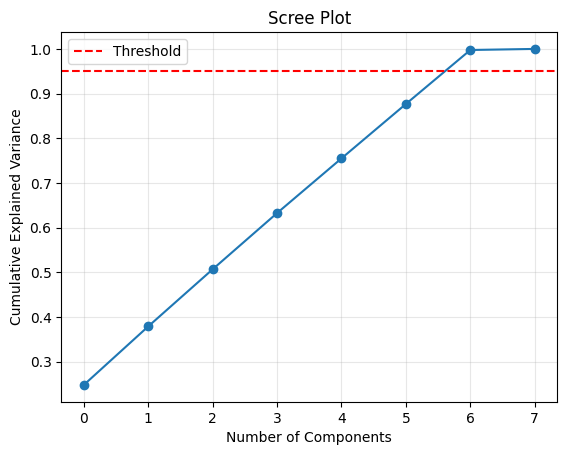

In [ ]:
#Scale the data for better accuracy for observations during PCA.
std_scaler = StandardScaler()
cev_threshold = 0.95 #Accept number of components that exceed the threshold of cumulative explained variance. Default value is 0.95.



def scale_data(param_scaler, param_features, param_data):
    scaled_array = param_scaler.fit_transform(param_data[param_features])
    return pd.DataFrame(scaled_array, columns=param_features, index=param_data.index)



def pca_component_plot(param_scaler, param_features, param_data, param_threshold):
    PCA_data_scaled = scale_data(param_scaler, param_features, param_data)

    pca_model = PCA()
    pca_model.fit(PCA_data_scaled)

    plt.plot(np.cumsum(pca_model.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')

    plt.grid(True, alpha=0.3)
    plt.axhline(y=param_threshold, color='red', linestyle='--', label='Threshold')
    plt.legend()
    plt.show()



pca_component_plot(std_scaler, fa_features, data, cev_threshold)

**Accept n_component as 6.**

In [ ]:
def pca_weightings(param_scaler, param_features, param_data, param_components, param_showRatio="", param_modelReturn=""):
    PCA_data_scaled = scale_data(param_scaler, param_features, param_data)

    pca_model = PCA(n_components=param_components)
    pca_values = pca_model.fit_transform(PCA_data_scaled)
    offset = 1

    for x, pc in enumerate(pca_model.components_):
        print(f'Principal Component {x + offset}:')

        for pcx, feature in enumerate(pc):
            print(f'{param_features[pcx]}: {feature:.4f}')

        print('\n')

        if(str.lower(param_showRatio) == 'yes'):
            print(f'PC{x + offset} Variance Ratio: {pca_model.explained_variance_ratio_[x]:.4f}')
            print('\n')

    if(str.lower(param_modelReturn) == 'yes'):
        return pca_model, pca_values




pca_weightings(std_scaler, fa_features, data, 6)

Principal Component 1:
IQ: -0.0006
Prev_Sem_Result: 0.7064
CGPA: 0.7064
Academic_Performance: -0.0065
Communication_Skills: -0.0251
Extra_Curricular_Score: 0.0150
Projects_Completed: 0.0288
Internship_Experience: -0.0185


Principal Component 2:
IQ: -0.0996
Prev_Sem_Result: 0.0055
CGPA: 0.0077
Academic_Performance: 0.6136
Communication_Skills: -0.4464
Extra_Curricular_Score: 0.1083
Projects_Completed: -0.2610
Internship_Experience: 0.5783


Principal Component 3:
IQ: 0.6852
Prev_Sem_Result: -0.0180
CGPA: -0.0165
Academic_Performance: -0.0907
Communication_Skills: -0.4681
Extra_Curricular_Score: -0.0637
Projects_Completed: 0.5357
Internship_Experience: 0.1070


Principal Component 4:
IQ: -0.0923
Prev_Sem_Result: -0.0164
CGPA: -0.0132
Academic_Performance: 0.1793
Communication_Skills: 0.1547
Extra_Curricular_Score: 0.8772
Projects_Completed: 0.4009
Internship_Experience: -0.0696


Principal Component 5:
IQ: 0.6521
Prev_Sem_Result: 0.0185
CGPA: 0.0173
Academic_Performance: -0.0985
Communi

Where Principle Component 1 explains the most data variance, with higher indexes being less robust.
- Prioritise PC1 findings.
- PC2 & PC3 has less importance than PC1, but still contains highly revelant information.
- PC4 & PC5 should be used as supplementary information rather than facts.
- PCA (Weightings) > KMO score (Feature suitability).
- Strong contributions in **multiple** PC means greater robustness of the feature, in the context of ```Student_Score``` structure.
- Strong PC1 > Multiple Strong PCs (PC1 is more structural dominant - Narrow but strong influence > Broad but weak).

#### Breakdown of Results: ####
- ```CGPA``` + ```Prev_Sem_Result```: have the greatest contribution in PC1 (most important component).
    - Consider giving greatest weighting.
- ```Internship_Experience``` + ```Academic_Performance```: have the greatest contribution in PC2.
    - ```Academic_Performance``` had poor KMO, and had high contributions in *ONLY* PC2 which should be factored in.
    - ```Internship_Experience``` had the highest loading in PC5.
- ```Projects_Completed``` + ```IQ```: have the greatest contribution in PC3.
    - ```Projects_Completed``` had a *high* KMO value, and is has high contribution in PC4.
    - ```IQ``` has poor contribution in all other PCs.
- ```Extra_Curricular_Score```.
    - Strong contribution in PC4 but nothing else.
    - Rejected by KMO score.
- ```Communication_Skills```.
    - Has *high* KMO value.
    - Only strong contribution is in PC5.

#### Strong Features: ####
- ```CGPA``` - Excellent PC1 & strongly correlated with ```Prev_Sem_Result``` - **Core feature**.
- ```Prev_Sem_Result``` - Excellent PC1 & strongly correlated with ```CGPA``` - **Core feature**.
- ```Internship_Experience``` - Strong in PC2 & PC5.
- ```Projects_Completed``` - Strong in PC3 & PC4.

#### Weak Features (Consider dropping): ####
- ```Academic_Performance``` - Only strong in PC2, and the only feature to be rejected by KMO score.
- ```IQ``` - Only strong in PC3.
- ```Extra_Curricular_Score``` - Neglible contribution in all but PC4.
- ```Communication_Skills``` - Neglible contribution in all but PC5, the weakest PC.

#### 3.3.1 - Re-Run PCA (Dimensionality Reduction)
Determining what features to drop by running PCA without x weak feature.

Without ```Communication_Skills```.

['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Extra_Curricular_Score', 'Projects_Completed', 'Internship_Experience']


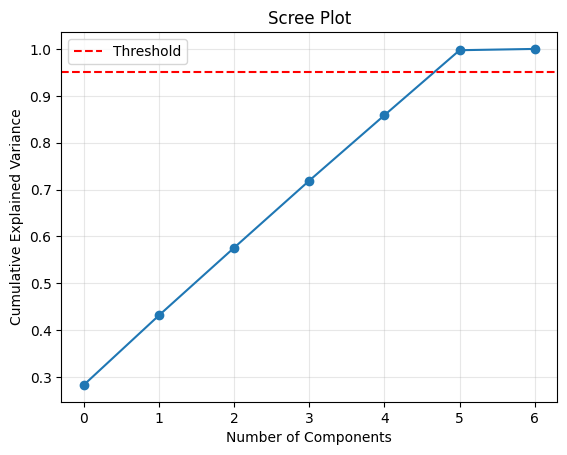

In [ ]:
features_dr_communication = fa_features.copy()
features_dr_communication.remove('Communication_Skills')
print(features_dr_communication)

pca_component_plot(std_scaler, features_dr_communication, data, cev_threshold)

In [ ]:
pca_weightings(std_scaler, features_dr_communication, data, 5)

Principal Component 1:
IQ: -0.0009
Prev_Sem_Result: 0.7066
CGPA: 0.7066
Academic_Performance: -0.0070
Extra_Curricular_Score: 0.0151
Projects_Completed: 0.0287
Internship_Experience: -0.0191


Principal Component 2:
IQ: -0.3455
Prev_Sem_Result: 0.0163
CGPA: 0.0177
Academic_Performance: 0.6228
Extra_Curricular_Score: 0.1699
Projects_Completed: -0.4390
Internship_Experience: 0.5202


Principal Component 3:
IQ: 0.4476
Prev_Sem_Result: -0.0143
CGPA: -0.0106
Academic_Performance: 0.2542
Extra_Curricular_Score: 0.5934
Projects_Completed: 0.5567
Internship_Experience: 0.2698


Principal Component 4:
IQ: -0.6070
Prev_Sem_Result: -0.0158
CGPA: -0.0148
Academic_Performance: -0.0559
Extra_Curricular_Score: 0.6281
Projects_Completed: 0.0747
Internship_Experience: -0.4773


Principal Component 5:
IQ: -0.5388
Prev_Sem_Result: -0.0068
CGPA: -0.0056
Academic_Performance: 0.0744
Extra_Curricular_Score: -0.3948
Projects_Completed: 0.6911
Internship_Experience: 0.2657




#### Breakdown of Results: ####
- n_components dropped to 5.
    - Model needs less components to explain the same degree of variance. 
    - An obvious sign of a cleaner & robust structure.
    - Suggests that ```Communication_Skills``` introduced noise into the structure or was redundant.
- Loadings have increased across the features & components.
    - ```CGPA``` & ```Prev_Sem_Result``` remain strong in PC1, reinforncing the fact that they are suitable core features.
    - PC3 now has muddled loadings for various features.

**Therefore drop ```Communication_Skills```**.

Without ```Extra_Curricular_Score```.

['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Projects_Completed', 'Internship_Experience']


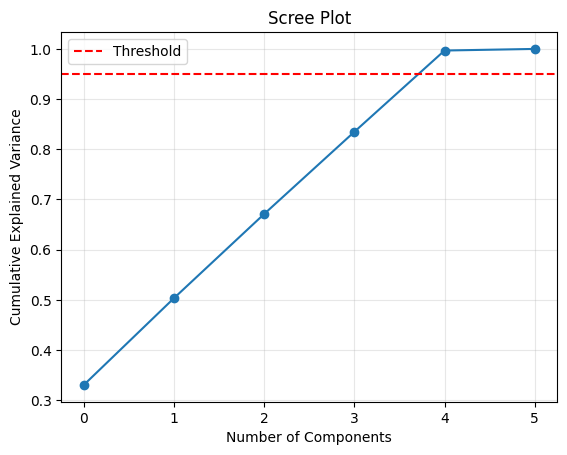

In [ ]:
features_dr_ecs = features_dr_communication.copy()
features_dr_ecs.remove('Extra_Curricular_Score')
print(features_dr_ecs)

pca_component_plot(std_scaler, features_dr_ecs, data, cev_threshold)

In [ ]:
pca_weightings(std_scaler, features_dr_ecs, data, 4)

Principal Component 1:
IQ: -0.0008
Prev_Sem_Result: 0.7067
CGPA: 0.7067
Academic_Performance: -0.0072
Projects_Completed: 0.0286
Internship_Experience: -0.0191


Principal Component 2:
IQ: -0.3517
Prev_Sem_Result: 0.0193
CGPA: 0.0202
Academic_Performance: 0.6064
Projects_Completed: -0.4828
Internship_Experience: 0.5241


Principal Component 3:
IQ: 0.6977
Prev_Sem_Result: -0.0004
CGPA: 0.0018
Academic_Performance: 0.2723
Projects_Completed: 0.4040
Internship_Experience: 0.5252


Principal Component 4:
IQ: -0.5470
Prev_Sem_Result: -0.0161
CGPA: -0.0133
Academic_Performance: 0.3266
Projects_Completed: 0.7697
Internship_Experience: -0.0347




#### Breakdown of Results: ####
- n_components dropped to 4.
    - Model needs less components to explain the same degree of variance. 
    - An obvious sign of a cleaner & robust structure.
    - Suggests that ```Extra_Curricular_Score``` introduced noise into the structure or was redundant.
- Loadings have increased across the features & components.
    - ```CGPA``` & ```Prev_Sem_Result``` remain strong in PC1, reinforncing the fact that they are suitable core features.
    - ```IQ``` is the dominant feature in PC3, with ```Projects_Completed``` and ```Internship_Experience``` being split.
        - Suggests removal of noise, due to more distinct relationships being defined.

**Therefore drop ```Extra_Curricular_Score```**.

Without ```Academic_Performance```.

['IQ', 'Prev_Sem_Result', 'CGPA', 'Projects_Completed', 'Internship_Experience']


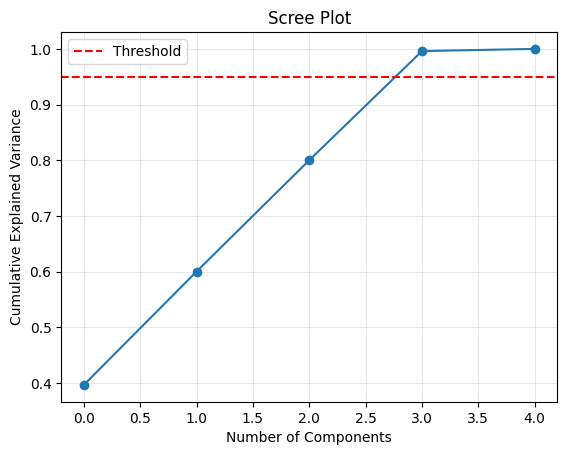

In [ ]:
features_dr_academic = features_dr_ecs.copy()
features_dr_academic.remove('Academic_Performance')
print(features_dr_academic)

pca_component_plot(std_scaler, features_dr_academic, data, cev_threshold)

In [ ]:
pca_weightings(std_scaler, features_dr_academic, data, 3)

Principal Component 1:
IQ: -0.0009
Prev_Sem_Result: 0.7067
CGPA: 0.7067
Projects_Completed: 0.0285
Internship_Experience: -0.0189


Principal Component 2:
IQ: 0.6191
Prev_Sem_Result: -0.0192
CGPA: -0.0177
Projects_Completed: 0.7049
Internship_Experience: -0.3452


Principal Component 3:
IQ: 0.5069
Prev_Sem_Result: 0.0120
CGPA: 0.0127
Projects_Completed: -0.0227
Internship_Experience: 0.8615




#### Breakdown of Results: ####
- Components dropped from **4** to **3**.
    - Similar case to ```Communication_Skills``` - Less complexity needed to explain the same variance when removed.
    - ```Academic_Performance``` either introduced noise, or can be explained by other features (e.g. ```Prev_Sem_Results``` and/or ```CGPA```), making it redundant to the structure.
- Better clarity for other component loadings.
    - ```CGPA``` & ```Prev_Sem_Results``` remain dominant in PC1.
    - ```IQ``` now has a strong contribution in PC2 (alongside ```Projects_Completed```) with retained moderate contribution in PC3 (alongside ```Internship_Experience```).
- Additionally showed poor KMO score previously.

**Therefore drop ```Academic_Performance```**.

Without ```IQ```.

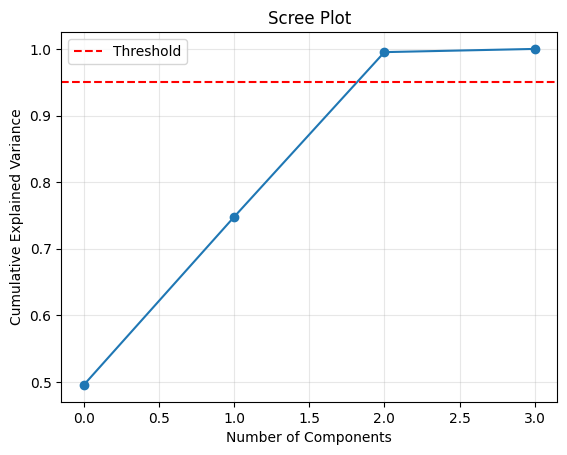

In [ ]:
feature_dr_iq = features_dr_academic.copy()
feature_dr_iq.remove('IQ')
#print(feature_dr_iq)

pca_component_plot(std_scaler, feature_dr_iq, data, cev_threshold)

In [ ]:
pca_weightings(std_scaler, feature_dr_iq, data, 2)

Principal Component 1:
Prev_Sem_Result: 0.7067
CGPA: 0.7067
Projects_Completed: 0.0285
Internship_Experience: -0.0189


Principal Component 2:
Prev_Sem_Result: 0.0242
CGPA: 0.0231
Projects_Completed: -0.6986
Internship_Experience: 0.7148




#### Breakdown of Results: ####
- Components reduced from **3** to **2**.
    - ```IQ``` has a similar issue to the previous two features of either introducing noise, or being explained by other features.
    - However, variance may not be captured by remaining feature - not necessarily noise, and can still be meaningful.
- Clarity of component weightings has decreased when removed.
    - ```Internship_Experience``` pairs with nothing in PC2 - **Isolated**.
    - ```Projects_Completed``` has weak contribution in both PC1 or PC2, leading to the issue of also being removed from the structure.

Considerations:
- Statistical Optimization != Practical Usefulness
    - Reducing too many features may reduce predictive power, which is counter-intuitive to the original intent of creating a ```Student_Score```.
    - PCA is designed to compress variance not predict an outcome, therefore not an absolute indicator.
- ```IQ``` somewhat pairs well with both ```Projects_Completed``` & ```Internship_Experience```.
    - Both features are objective indicators, compared to ```Academic_Performance``` & ```Communication_Skills``` which can be subjective (and objective).
- Removing ```IQ``` will likely lead to removing ```Projects_Completed```, which can also potentially lead to removing ```Internship_Experience```.
    - These features represent non-academic capability.
    - Placements are unlikely to be decided by academic metrics alone in a real-world scenario.

**Therefore keep ```IQ``` for now; as it maintains structural integrity of non-academic elements. Re-evaluate if prompted in future tests**.

### 3.4 - RandomForest

Determine the split between placement totals (Yes/No) for standardized data sample, in the event of class imbalance.

In [ ]:
count_placements = data.loc[data['Placement'] == 1, 'Placement'].count()
print(f'{count_placements} placements out of {data.shape[0]}')

1659 placements out of 10000


#### Stratified Sampling ####
Ensuring that an equal split is present in the sample so that data accuracy is not greatly affected.

In [ ]:
placement_yes = data[data['Placement'] == 1]
placement_no = data[data['Placement'] == 0]

#Take a sample using the maximum amount of the smallest group, from the largest group.
placement_no_resampled = resample(placement_no, replace=False, n_samples=count_placements, random_state=1)
#print(placement_no_resampled.count())

#Combine both samples.
placement_resampled = pd.concat([placement_yes, placement_no_resampled])
#print(placement_resampled.loc[placement_resampled['Placement'] == 1, 'Placement'].count())

#Shuffle the data to remove possible bias when handling.
placement_resampled = placement_resampled.sample(frac=1, random_state=1).reset_index(drop=True)

#### Model Parameters ####

In [ ]:
placement_features = features_dr_academic.copy()
#print(placement_features)

placement_x = placement_resampled[placement_features]
placement_y = placement_resampled['Placement']

placement_labels = ['No', 'Yes']

#### Creating the RandomForest Model ####

IQ Importance: 0.3190
Prev_Sem_Result Importance: 0.1571
CGPA Importance: 0.3080
Projects_Completed Importance: 0.2150
Internship_Experience Importance: 0.0010


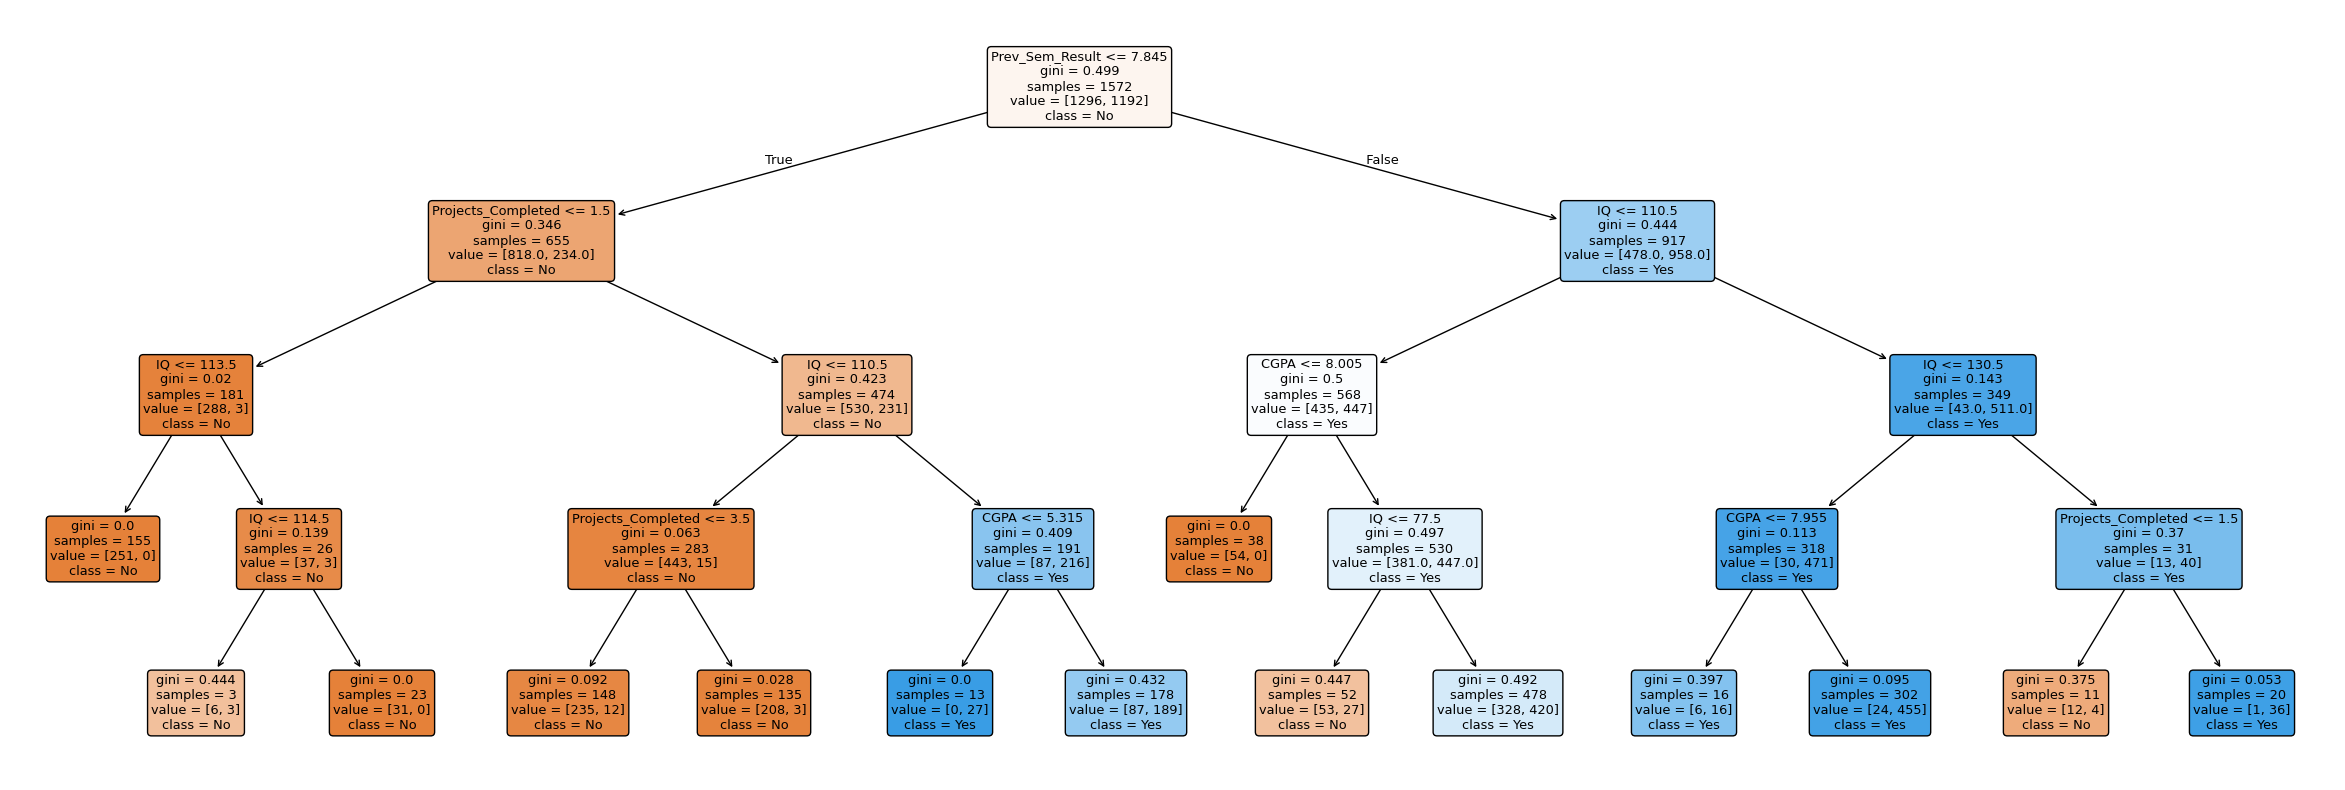

In [ ]:
#Create the decision tree for random forest model.
def plot_forest(param_estimator, param_x, param_labels):
    plt.figure(figsize=(30,10))
    plot_tree(param_estimator, feature_names=param_x.columns, class_names=param_labels, filled=True, rounded=True)
    plt.show()



def get_importance(param_model, param_features):
    for x, feature in enumerate(param_features):
        print(f'{feature} Importance: {param_model.feature_importances_[x]:.4f}')



#Generate a model for random forest of x depth, returning test nd predicted data of y values.
def forest_model(param_x, param_y, param_depth, param_features):
    x_train, x_test, y_train, y_test = train_test_split(param_x, param_y, test_size=0.25, random_state=1)

    forest_model = RandomForestClassifier(random_state=1, max_depth=param_depth)
    forest_model.fit(x_train, y_train)

    y_predict = forest_model.predict(x_test)
    estimator = forest_model.estimators_[0]
    
    #Return importance level of each feature in the model.
    get_importance(forest_model, param_features)

    #Plot the model.
    plot_forest(estimator, x_train, placement_labels)

    return y_test, y_predict



placement_test, placement_predict = forest_model(placement_x, placement_y, 4, placement_features)

#### 3.4.1 - Validating the Model

**Accuracy Score**

In [ ]:
def validate_accuracy_score(param_test, param_predict):    
    print(f'Accuracy Score: {accuracy_score(param_test, param_predict):.4f}')

validate_accuracy_score(placement_test, placement_predict)

Accuracy Score: 0.8627


**F1 Score**

In [ ]:
def validate_f1_score(param_test, param_predict, param_labels):
    f1 = f1_score(param_test, param_predict, average=None)
    print(f'F1 Score ({param_labels[0]}): {f1[0]:.4f}')
    print(f'F1 Score ({param_labels[1]}): {f1[1]:.4f}')

validate_f1_score(placement_test, placement_predict, placement_labels)

F1 Score (No): 0.8376
F1 Score (Yes): 0.8810


**Confusion Matrix**

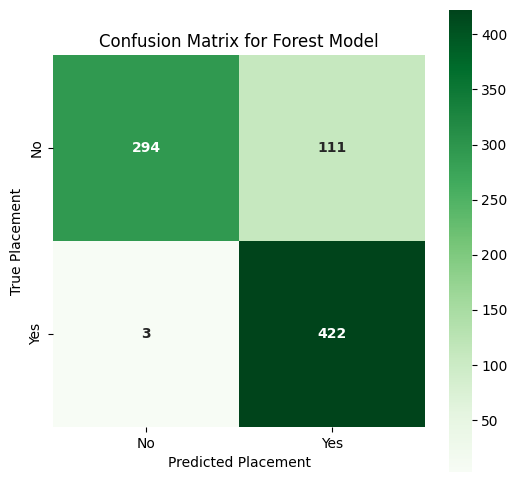

In [ ]:
def validate_confusion(param_test, param_predict, param_labels):
    forest_confusion = confusion_matrix(param_test, param_predict)
    #print(confusion_matrix(param_test, param_predict))

    plt.figure(figsize=(6,6))
    sns.heatmap(forest_confusion, cmap='Greens', square=True, annot=True, annot_kws={'fontweight' : 'bold'}, fmt='g', xticklabels=param_labels, yticklabels=param_labels)
    plt.title('Confusion Matrix for Forest Model')
    plt.xlabel('Predicted Placement')
    plt.ylabel('True Placement')
    plt.show()

validate_confusion(placement_test, placement_predict, placement_labels)

#### Breakdown of Results: ####
Forest Model
- According to feature importances in the model - ```Internship_Experience``` has negligble contribution.
    - Re-test without this feature. **Drop if** accuracy remains the same OR increases.
- ```IQ``` has the greatest *overall* influence on the model.
    - Suggests previous assumption on IQ being relevant to the model is valid, and should therefore be kept.
- ```CGPA``` has a strong contribution, with ```Prev_Sem_Results``` & ```Projects_Completed``` playing a supporting role.

Validation
- Accuracy score of 86.27% - Solid performance.
    - Great accuracy, neither under or overfitting.
- F1 scores above 80% for both categories.
    - Better at predicting Yes outcomes, but a great performance on both ends.
- Confusion Matrix:
    - Exceptionally low false negative values - Almost always accuractely predicts students who will get a placement.
    - Moderate amount of false positives - The model is more inclined to giving students a placement, even if they are not suitable.
        - Features may not fully capture real-world complexity, therefore more room for fine-tuning.

#### 3.4.2 - Forest Model (Without ```Internship_Experience```)

**Model Parameters**

In [ ]:
placement_features = features_dr_academic.copy()
placement_features.remove('Internship_Experience')
print(placement_features)

placement_x = placement_resampled[placement_features]
placement_y = placement_resampled['Placement']

['IQ', 'Prev_Sem_Result', 'CGPA', 'Projects_Completed']


**Generate Random Forest Model**

IQ Importance: 0.3524
Prev_Sem_Result Importance: 0.1547
CGPA Importance: 0.2978
Projects_Completed Importance: 0.1951


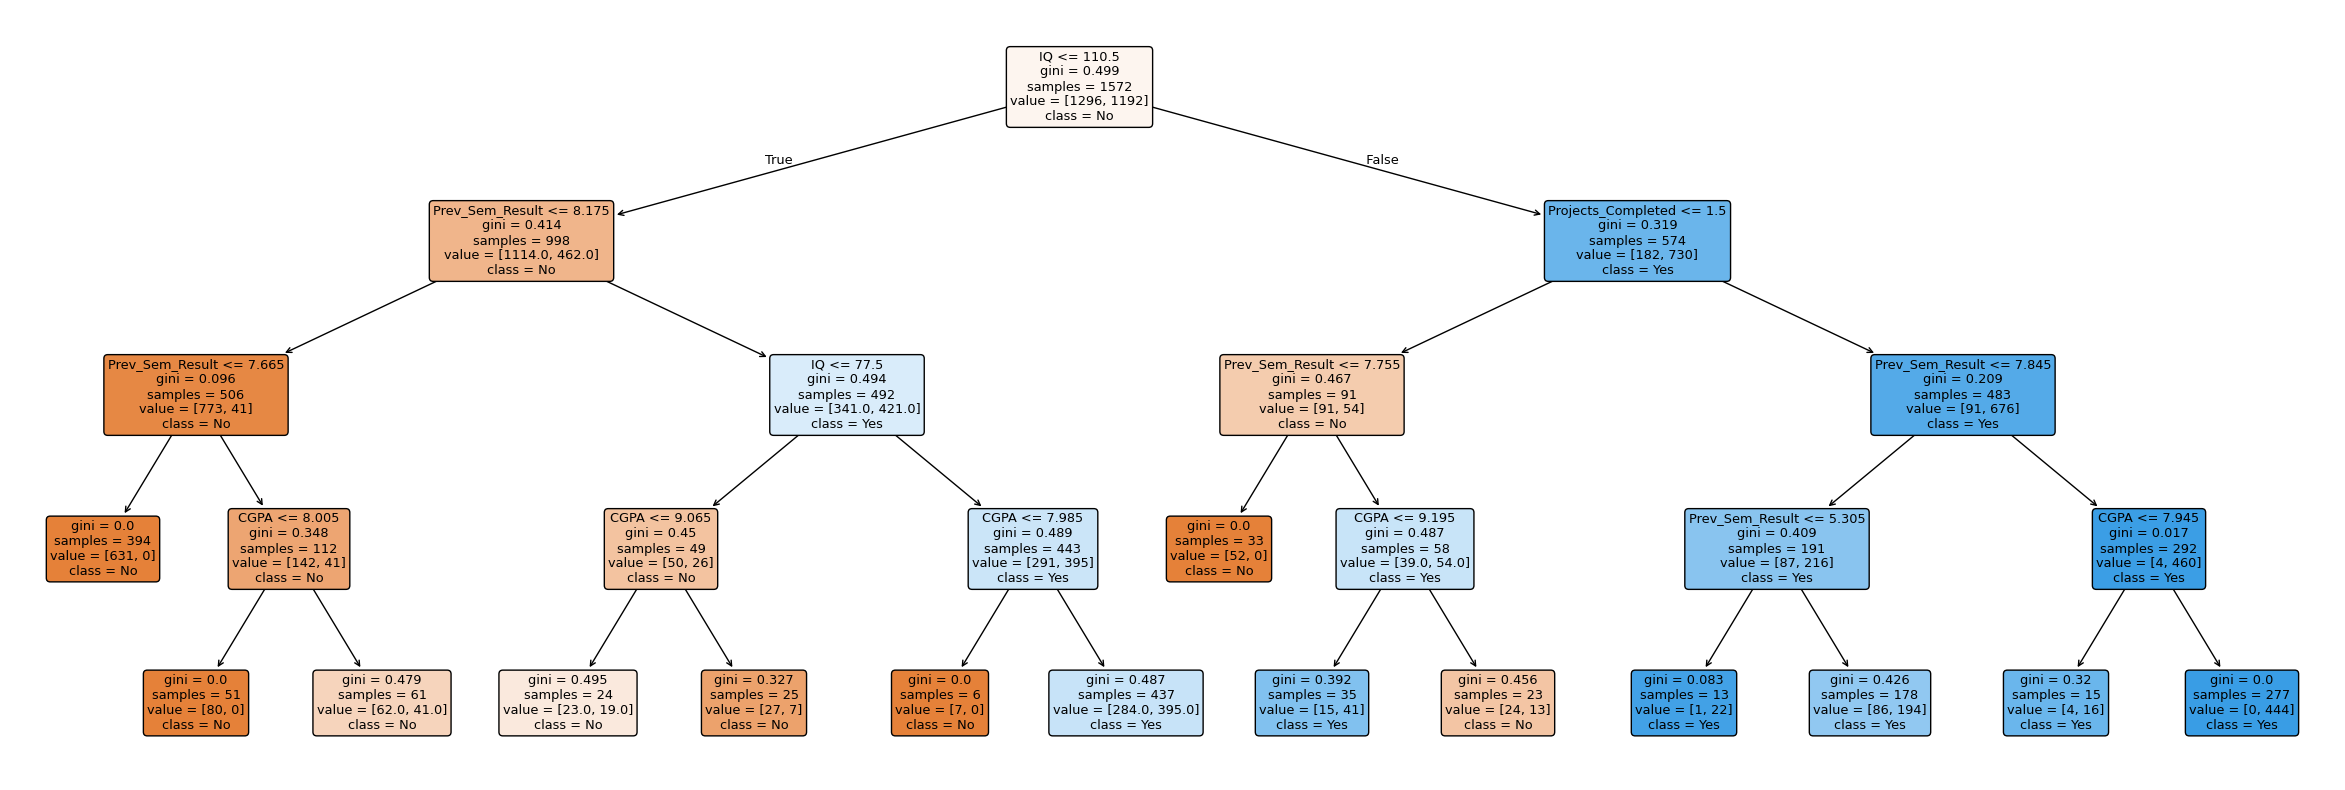

In [ ]:
placement_test, placement_predict = forest_model(placement_x, placement_y, 4, placement_features)

**Accuracy Score**

In [ ]:
validate_accuracy_score(placement_test, placement_predict)

Accuracy Score: 0.8614


**F1 Score**

In [ ]:
validate_f1_score(placement_test, placement_predict, placement_labels)

F1 Score (No): 0.8364
F1 Score (Yes): 0.8798


**Confusion Matrix**

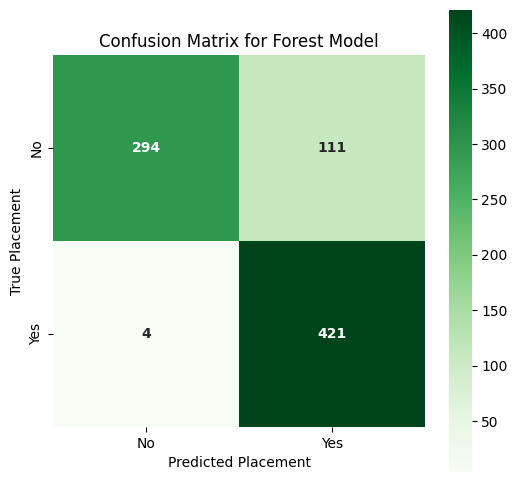

In [ ]:
validate_confusion(placement_test, placement_predict, placement_labels)

#### Breakdown of Results: ####
Model
- Not much has changes asides from weighting values being shuffled around, which was expected.

Validation
- Accuracy score is -0.0013.
    - A negligible difference.
- F1 score is -0.0012 for both.
    - A negligble difference.
- Confusion Matrix +1 for false negative.
    - A negligble difference.

<br> **Summary:**
- Removing ```Internship_Experience``` has no statistically significant impact on the accuracy (although it does decrease it).
    - It is OK to remove this feature for a more optimized model (simpler), however the model hasn't become more accurate as a result.
- Conversely, the fact that removing ```Internship_Experience``` has no meaningful impact also suggests that there is no harm keeping it.

<br> **Considerations:**
- ```Internship_Experience``` has significant real-world value.
    - Removing the feature reduces the credibility of the model in the eyes of stakeholders.
    - This model may not accurately capture the feature, however other models might.
        - ```IQ``` was previously shown to be a poor fit for PCA, but has shown to be excellent for RandomForest.
- This feature has interactions with ```IQ```.
    - According to PCA.
    - Although on its own ```Internhip_Experience``` may not be a strong predictor, it may be when combined with other features.
    - Deeper decision trees may potentially demonstrate this fact.
- Model Flexibility
    - ```Internship_Experience``` adds a layer of complexity, which can be utilized for specialized tuning.
    - The current model is generalized, however what if we want to create a ```Student_Score``` for colleges with *high entry requirements*?
- Scalability
    - The dataset will gradually become larger, which in turn affects the (hidden) patterns shown in the model.
    - Keeping ```Internship_Experience``` ensures that the model is at least somewhat *future-proof* and adaptable.

<br> **Conclusion - Keep ```Internship_Experience``` for now, as there is no justifiable reason to remove it at this stage.**

## 4. **Feature Engineering**

#### Constructing a Preliminary Formula ####
Points of Interest:
- ```CGPA``` & ```Prev_Sem_Results``` have shown to be interlinked, and have core contribution.
    - Very strong linear relationship (**0.98**) shown with a correlation matrix, and proven to be statistically significant.
    - Both around equal contribution in PC1.
    - Both represent objective *academic performance* in the real-world.
- ```IQ```, ```Project_Completed```, & ```Internship_Experience``` supplement core features.
    - Each feature has mixed results across the three tests, but has proven to have enough of an impact in predicting placements.
    - The three features, serve as a metric for *non-academic* performance of a student.
    - ```IQ``` has shown to be the strongest predictor in the RF model.

Considerations:
- Data format variance exists.
    - A mix of: continuous, discrete integers, and binary values are present within these 5 features.
    - We need to normalize the data prior to weightings.
- We have two *'groups'* of data.
    - Academic & non-academic metrics.
- Features need to be weighted accordingly to their value, based on findings and real-world relevance.
- For readability purposes, the ```Student_Score``` will be a scale of 0 - 100.

**Methodology:**
- Have a 50:50 split for academic (```CGPA``` & ```Prev_Sem_Results```) to non-academics (everything else) weightings.
    - The real-world typically places more importance on academics, but we are comparing 2 features by 3.
    - Weightings can be fine tuned in the future, but for simplicity - a 50:50 split is sufficient.
- Academic elements will be combined into a single feature.
    - A strong proven linear relationship.
    - ***```Academic_Avg``` = (```CGPA``` + ```Prev_Sem_Results```) / 2***
- ALL features will be normalized (0-1) before applying weights.
- Weightings will be:
    - ```Academic_Avg``` = 0.5
    - ```IQ``` = 0.2
    - ```Projects_Completed``` = 0.15
    - ```Internship_Experience``` = 0.15
    - **Note:** 
        - ```Projects_Completed``` & ```Internship_Experience``` are likely subject to change.
        - ```Projects_Completed``` vary depending on quality/scale - Data currently only captures quantity.
        - ```Internship_Experience``` carries external validation from a company, which can great weight from a real-world perspective.
- Weighted values will be added, before setting the scale to 100.

### 4.1 - Initial Formula
```Student_Score``` = 100 * ( <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 0.5 * ((```CGPA``` + ```Prev_Sem_Result```) / 2) + <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 0.2 * ```IQ``` + <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 0.15 * ```Projects_Completed``` + <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 0.15 * ```Internship_Experience``` <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; )

#### ```Student_Score``` Feature Pre-Processing ####

In [ ]:
#Create Academic_Avg.
data['Academic_Avg'] = (data['CGPA'] + data['Prev_Sem_Result']) / 2

#Create a copy of the original dataset for normalization.
normalized_data = data.copy()
cols_to_normalize = ['Academic_Avg', 'IQ', 'Projects_Completed', 'Internship_Experience']

mM_scaler = MinMaxScaler()

normalized_data[cols_to_normalize] = mM_scaler.fit_transform(normalized_data[cols_to_normalize])
print(normalized_data[cols_to_normalize].describe())

       Academic_Avg            IQ  Projects_Completed  Internship_Experience
count  10000.000000  10000.000000        10000.000000           10000.000000
mean       0.504872      0.499571            0.502680               0.396400
std        0.266630      0.166533            0.343192               0.489174
min        0.000000      0.000000            0.000000               0.000000
25%        0.277319      0.382022            0.200000               0.000000
50%        0.507805      0.494382            0.600000               0.000000
75%        0.734619      0.606742            0.800000               1.000000
max        1.000000      1.000000            1.000000               1.000000


#### ```Student_Score``` ####

In [ ]:
weight_academic_avg = 0.50
weight_iq = 0.20
weight_projects_completed = 0.15
weight_internship_experience = 0.15

data['Student_Score'] = 100 * (
    (weight_academic_avg * normalized_data['Academic_Avg']) + 
    (weight_iq * normalized_data['IQ']) + 
    (weight_projects_completed * normalized_data['Projects_Completed']) + 
    (weight_internship_experience * normalized_data['Internship_Experience'])
).round(4)

print(data['Student_Score'].describe())

count    10000.000000
mean        48.721182
std         16.403160
min          3.300000
25%         36.810000
50%         48.630000
75%         60.520000
max         95.210000
Name: Student_Score, dtype: float64


#### 4.1.1 - Plot the Distribution
For visual clarity and distribution of score.

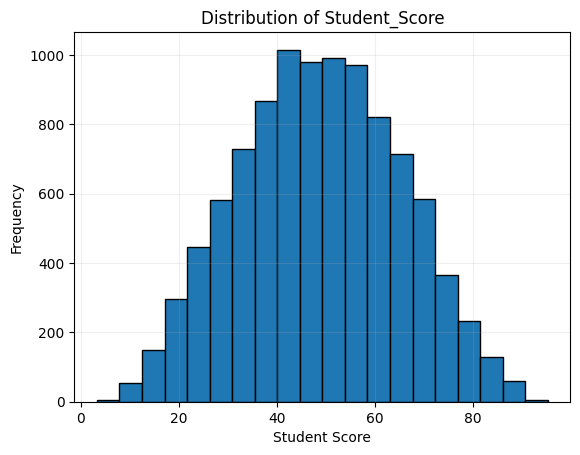

In [ ]:
plt.hist(data['Student_Score'], bins=20, edgecolor='black')
plt.grid(True, alpha=0.2)
plt.title('Distribution of Student_Score')
plt.xlabel('Student Score')
plt.ylabel('Frequency')
plt.show()

#### Breakdown of Results ####
- Scale of 0 - 100 is working correctly.
    - No minimum below 0.
    - No maximum above 100.
- Bell Curve - Even distribution.
- Average is a little below 50.
- The top 25% have a score above 60.

### 4.2 - Determining Critical Threshold for Placements
Using Student Score

#### 4.2.1 - RandomForest
**Sample & Model Parameters**

In [ ]:
placement_yes = data[data['Placement'] == 1]
placement_no = data[data['Placement'] == 0]

#Take a sample using the maximum amount of the smallest group, from the largest group.
placement_no_resampled = resample(placement_no, replace=False, n_samples=count_placements, random_state=1)
#print(placement_no_resampled.count())

#Combine both samples.
placement_resampled = pd.concat([placement_yes, placement_no_resampled])
#print(placement_resampled.loc[placement_resampled['Placement'] == 1, 'Placement'].count())

#Shuffle the data to remove possible bias when handling.
placement_resampled = placement_resampled.sample(frac=1, random_state=1).reset_index(drop=True)



score_x = placement_resampled[['Student_Score']]
score_y = placement_resampled['Placement']

Student_Score Importance: 1.0000


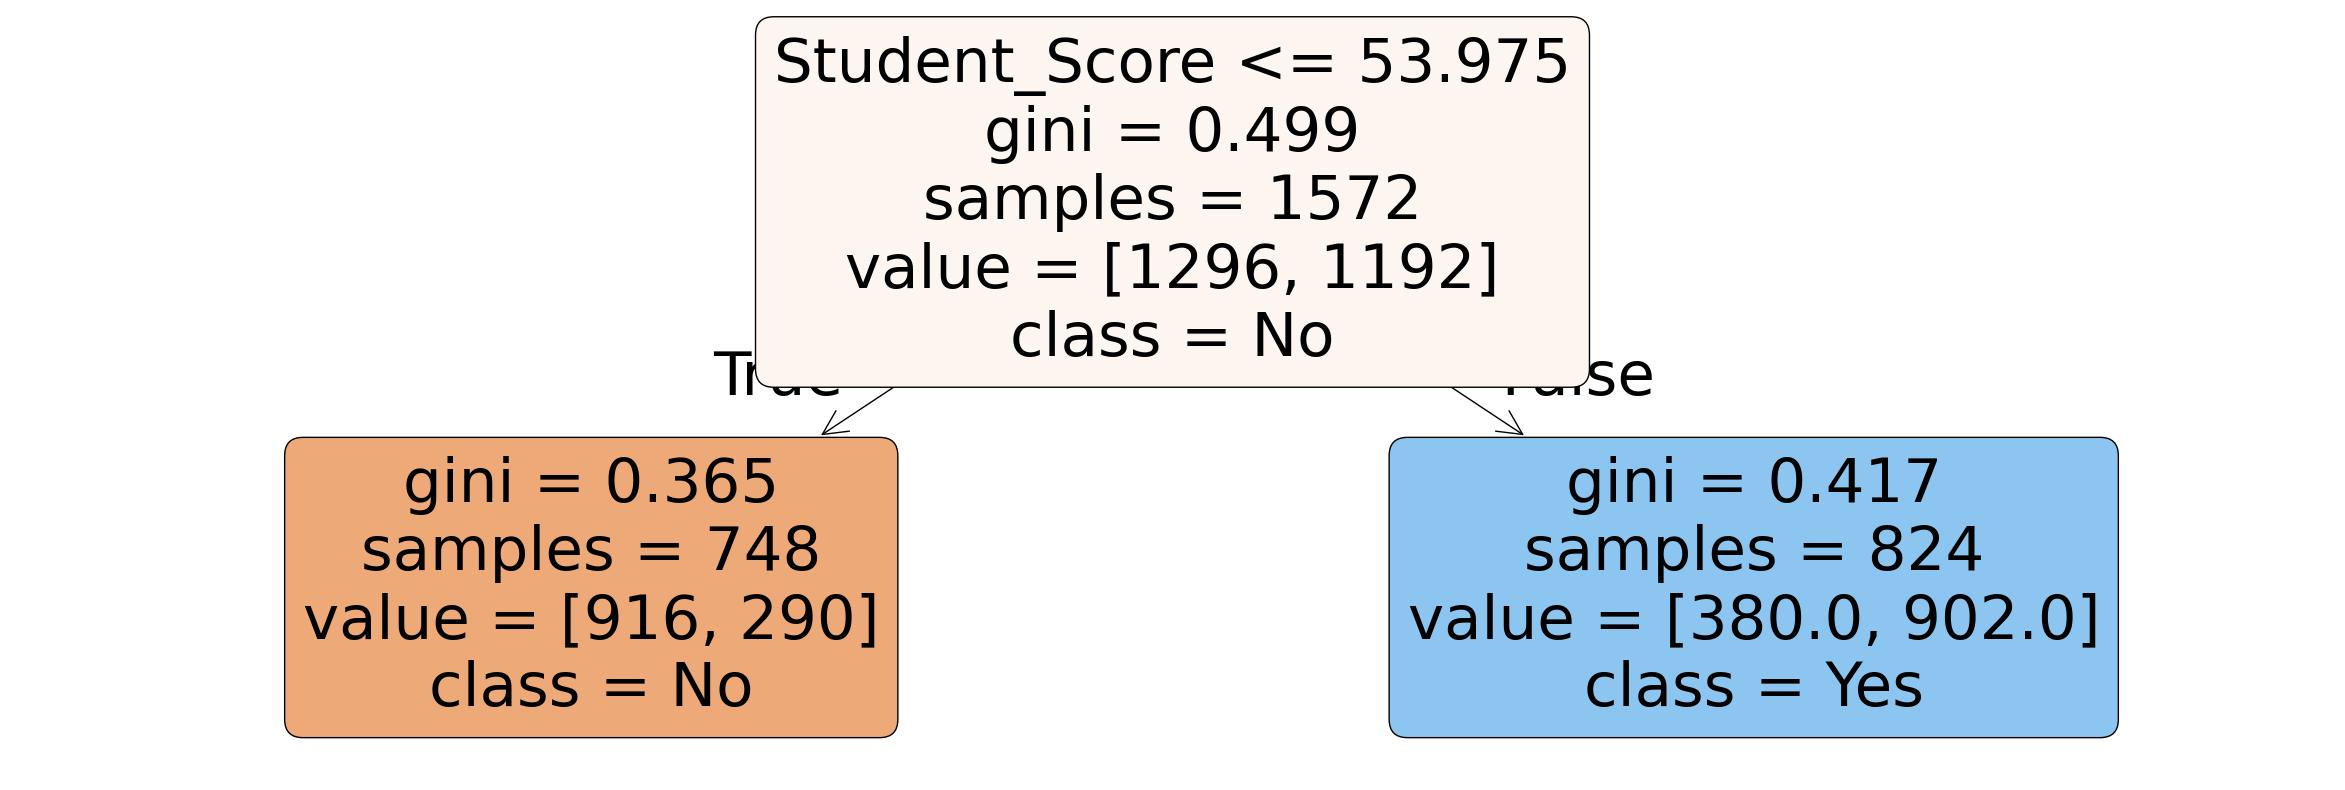

In [ ]:
score_test, score_predict = forest_model(score_x, score_y, 1, ['Student_Score'])

**Accuracy Score**

In [ ]:
validate_accuracy_score(score_test, score_predict)

Accuracy Score: 0.7422


**F1 Score**

In [ ]:
validate_f1_score(score_test, score_predict, placement_labels)

F1 Score (No): 0.7147
F1 Score (Yes): 0.7648


**Confusion Matrix**

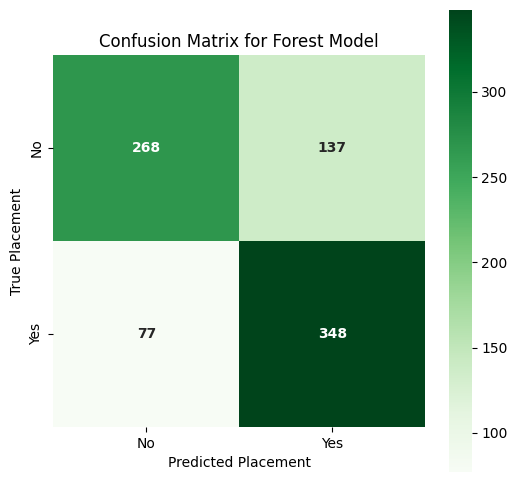

In [ ]:
validate_confusion(score_test, score_predict, placement_labels)

#### Breakdown of Results ####
- Initial decision boundary for ```Student_Score``` is **54**.
    - Assumes any student with a score equal or above 54, will receive a placement.
    - Assumes any student below 54, will not receive a placement.
- Threshold lies between the median (48.6) and upper quartile (60.5).
    - Threshold likely favours placements over non-placement predictions.
- Accuracy score of 0.74 is *reasonable* but has room for improvement.
- F1 scores are both above 0.7 which is okay - Both category predictions are roughly around the same.
    - Better performance on [Yes] placements (+0.05).
- Confusion Matrix has great classification of True Positives and True Negatives.
    - Better overall performance in predicting students who will receive a placement.
    - Threshold has a greater emphasis on predicting students who will receive a placement, rather than students who will not receive one.
    - Less false negatives than positives - Suggests caution on missing eligible candidates.
- **Overall accuracy is above baseline, with room for improvement.**

#### 4.2.2 - Logistic Regression

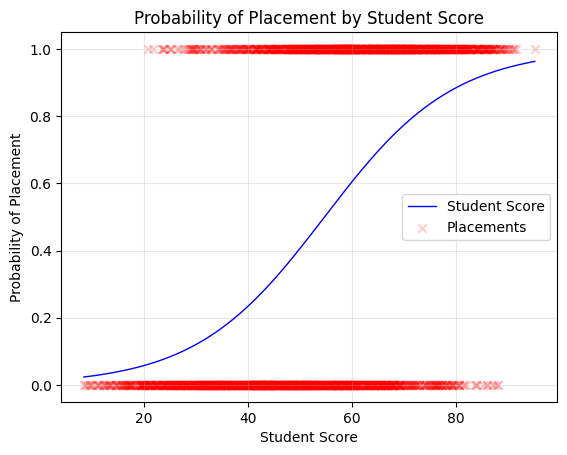

In [ ]:
logReg_model = LogisticRegression()
logReg_model.fit(score_x, score_y)


#Generate a series  of (500) evenly spaced points from min and max x values as test data. Then convert it into a multiple row (-1) by single column (1) array. Greater intervals improves line smoothness.
x_range = np.linspace(score_x.min(), score_x.max(), 500).reshape(-1, 1)
x_range = pd.DataFrame(x_range, columns=score_x.columns)

#Use the model to predict y-axis values for each x-axis value (500).
y_probs = logReg_model.predict_proba(x_range)[:, 1]


#Plot the model.
plt.plot(x_range, y_probs, color='blue', linewidth=1, label='Student Score')
plt.scatter(score_x, score_y, color="red", marker='x', alpha=0.2, label='Placements')
plt.title('Probability of Placement by Student Score')
plt.xlabel('Student Score')
plt.ylabel('Probability of Placement')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Getting the Threshold from the Model**

In [ ]:
logistic_cutoff = 0.5 #Default is 0.5 according to Bayes classifier.

closest_index = np.abs(y_probs - logistic_cutoff).argmin()
threshold_score = x_range.iloc[closest_index, 0]

print(f'Threshold Score = {threshold_score:.4f}')

Threshold Score = 54.6801


#### Validating the Model Accuracy ####

**Accuracy Score**

In [ ]:
#Convert probabilities into binary values for predictive classification.
y_pred_probs = logReg_model.predict_proba(score_x)[:, 1]
y_pred_class = (y_pred_probs >= logistic_cutoff).astype(int)

validate_accuracy_score(score_y, y_pred_class)

Accuracy Score: 0.7263


**F1 Score**

In [ ]:
validate_f1_score(score_y, y_pred_class, placement_labels)

F1 Score (No): 0.7213
F1 Score (Yes): 0.7312


**Confusion Matrix**

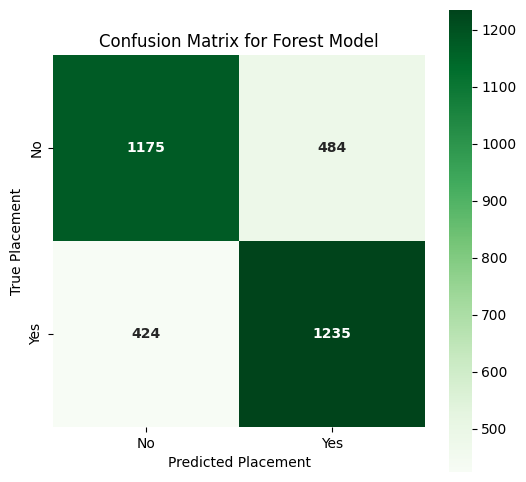

In [ ]:
validate_confusion(score_y, y_pred_class, placement_labels)

#### Breakdown of Results ####
- Based on a 0.5 probability cutoff for logistic regression - Threshold for a logistic model is **54.68**.
    - A higher threshold than the RF model.
    - Likely reducing the number of predicted [Yes] placements.
- Based on the graph:
    - Students with a score of **40** or less, have less than a **30%** chance of getting a placement.
    - Students with a score of **60**, have around a **60%** chance of getting a placement.
    - Students with a score of **80**, have around a **90%** chance of getting a placement.
- Accuracy score of 0.7263.
    - -0.0159 accuracy to RF model.
- F1 score of 0.7213 for [No] and 0.7312 for [Yes] predictions.
    - A more balanced accuracy.
    - Overall decrease in accuracy especially for predicting [Yes].
- Confusion matrix shows relatively balanced totals in Trues (1235:1175) and Falses (484:424).
    - A more overall balanced prediction for Yes and No placements.

Considerations:
- Colleges will have different requirements - therefore both threshold points are valid, but can be more suitable under certain contexts.
    - RF model is more suited for general use, prioritising quantity or quality.
    - Logistic model is more stricter - placing emphasis on quality, but less accurate in predicting overall.

#### Conclusion ###
- The threshold for ```Student_Score``` probably shouldn't be used as an absolute metric in the first place, but rather a guide.
- RF model threshold of 54 is more suited overall, being more pragmatic for general college use, as it gives more flexibility in decision making (less strict).
- Consider identifying a threshold for students who are unlikely to receive a placement for targetted actions (e.g. automatic decline or alternatives).

## 5. **College Segmentation**

Aims & Objectives:
- Segment ```College_ID``` based on available features.
    - Academic & Non-Academic.
    - PCAs can be used to group features onto an x (academic) and y-axis (non-academic).
- Identify nautral groupings using KMeans clustering.
    - Can identify natural clusters based on aggregation of ```College_ID``` in a PCA space.
    - More flexible than quartile binning in terms of grouping.
- Determine an appropriate number of clusters to be used.
    - Use silhouette scores (or Calinski-Harabasz index).
- Plot ```College_ID``` on a KMeans cluster plot.
- Interpret and assign labels based on clusters (e.g. high-academic, low-non-academic performance).
- Fine-tune ```Student_Score``` for predicting ```Placement``` based on segmented colleges.

Considerations:
- KMeans segments data based on a spherical pattern.
    - Not suitable for un-even or ellogated sized groups.
- Interpretability is lowered as opposed to the simpler quartile binning method.
    - Non-technical stakeholders will find it more difficult to understand.
    - PCAs add onto this issue.
- PCAs do not fully interpret the dataset due to the uneven spread of loadings.
    - May induce some bias or misrepresent features through feature scaling and grouping.

**If poor KMeans cluster separation. Opt into quartile binning or a hybrid method.**

In [ ]:
#Define academic/non-academic features
academic_features = ['Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Projects_Completed']
non_academic_features = ['IQ', 'Internship_Experience', 'Communication_Skills', 'Extra_Curricular_Score']

**Aggregate for College_ID with Placements**
</br></br> We're grouping Colleges based on their requirements. </br>
So we *only* want the average values; of students who received a placement for the respective Colleges.

In [ ]:
#We only want 'Yes' Placements.
placement_received = data[data['Placement'] == 1]
college_data = placement_received.groupby('College_ID').mean()



colleges_academic = college_data[academic_features]
#print(colleges_academic)

colleges_non_academic = college_data[non_academic_features]
#print(colleges_non_academic)

**Components for Academic Features**

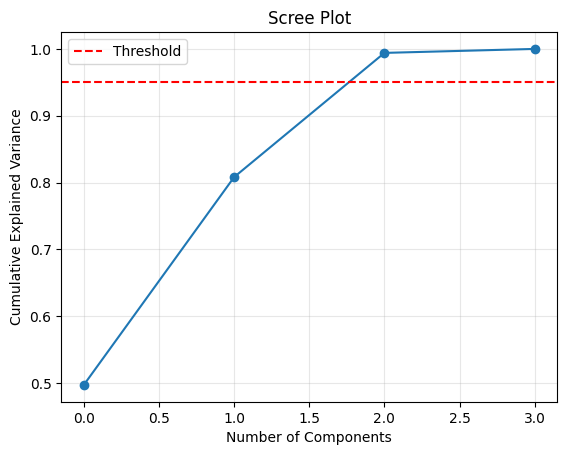

In [ ]:
pca_component_plot(std_scaler, academic_features, colleges_academic, cev_threshold)

**Components for Non-Academic Features**

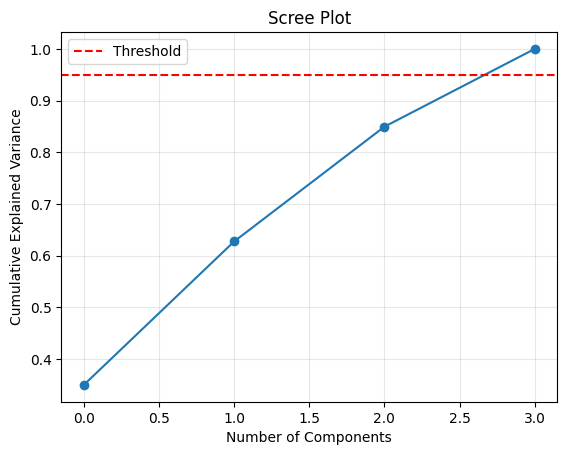

In [ ]:
pca_component_plot(std_scaler, non_academic_features, colleges_non_academic, cev_threshold)

#### Breakdown of Results ####
- Academic features produces a standard scree plot with a clear elbow.
    - **n_components is 2** when using a **cev_threshold**.
- Non-academic produces a line.
    - Suggests weak correlations (which is true based on correlation matrix).
    - Measures different independant qualities.
        - Variance is more evenly distributed amongst PCs (**n_components = 3** at **cev_threshold**).
    - Reduces the usefulness of only using PC1 as the axis.

Considerations:
- Rather than using PC1 which typically contains the most variance.
    - Try weighted averages, especially for non-academic features.
    - This will explain more variance, at the cost of increased complexity.

**Academic PCA Weightings**

In [ ]:
academic_model, academic_values = pca_weightings(std_scaler, academic_features, colleges_academic, 2, 'Yes', 'Yes')

Principal Component 1:
Prev_Sem_Result: 0.7037
CGPA: 0.7024
Academic_Performance: -0.0941
Projects_Completed: -0.0502


PC1 Variance Ratio: 0.4973


Principal Component 2:
Prev_Sem_Result: -0.0284
CGPA: -0.0144
Academic_Performance: -0.7009
Projects_Completed: 0.7126


PC2 Variance Ratio: 0.3109




**Non-Academic PCA Weightings**

In [ ]:
non_academic_model, non_academic_values = pca_weightings(std_scaler, non_academic_features, colleges_non_academic, 3,  'Yes', 'Yes')

Principal Component 1:
IQ: 0.6718
Internship_Experience: 0.2357
Communication_Skills: -0.6207
Extra_Curricular_Score: -0.3284


PC1 Variance Ratio: 0.3494


Principal Component 2:
IQ: -0.2144
Internship_Experience: 0.6554
Communication_Skills: 0.3518
Extra_Curricular_Score: -0.6330


PC2 Variance Ratio: 0.2777


Principal Component 3:
IQ: -0.2310
Internship_Experience: 0.6861
Communication_Skills: -0.3144
Extra_Curricular_Score: 0.6140


PC3 Variance Ratio: 0.2223




**Weighted PCA Axis Function**

In [ ]:
def weighted_pca(param_model, param_values, param_features, param_feature, param_nComponents):
    #Normalize variance ratio weights to avoid unfairly scaled blocks.
    normalize_weights = param_model.explained_variance_ratio_[:param_nComponents]
    normalize_weights = normalize_weights / normalize_weights.sum()

    #Anchor PCA sign flips to positive. Positive feature = positive axis.
    if param_model.components_[0, param_features.index(param_feature)] < 0:
        academic_values *= -1

    return np.dot(param_values[:, :param_nComponents], normalize_weights)

**Academic PCA**

In [ ]:
academic_axis = weighted_pca(academic_model, academic_values, academic_features, 'CGPA', 2)
#print(academic_axis)

**Non-Academic PCA**

In [ ]:
non_academic_axis = weighted_pca(non_academic_model, non_academic_values, non_academic_features, 'IQ', 3)
#print(non_academic_axis)

**Compile PCAs**

In [ ]:
segment_college_data = pd.DataFrame()

segment_college_data['Academic_PCA'] = academic_axis
segment_college_data['Non_Academic_PCA'] = non_academic_axis

#print(kmeans_college_data)

#print(kmeans_college_data['Academic_PCA'])
#print(kmeans_college_data['Non_Academic_PCA'])

**Absolute Explained Variance of Axes & Contribution**

In [ ]:
academic_variance = segment_college_data['Academic_PCA'].var()
non_academic_variance = segment_college_data['Non_Academic_PCA'].var()
total_variance = academic_variance + non_academic_variance

print(f"Academic_Axis Explained Variance: {academic_variance:.4f}")
print(f"Non_Academic_Axis Explained Variance: {non_academic_variance:.4f}")

#Calculate the contribution of both axes using the relative variance.

academic_contribution = (academic_variance / total_variance) * 100
non_academic_contribution = (non_academic_variance / total_variance) * 100

print('')

print(f"Academic Contribution: {academic_contribution:.2f}%")
print(f"Non_Academic Contribution: {non_academic_contribution:.2f}%")


Academic_Axis Explained Variance: 0.9466
Non_Academic_Axis Explained Variance: 0.4204

Academic Contribution: 69.25%
Non_Academic Contribution: 30.75%


### 5.1 - K-Means Clustering

**Silhouette Scores for Suitable K Value**

Where k=2, Silhouette Score: 0.3931
Where k=3, Silhouette Score: 0.3741
Where k=4, Silhouette Score: 0.3755
Where k=5, Silhouette Score: 0.3481
Where k=6, Silhouette Score: 0.3233
Where k=7, Silhouette Score: 0.3227
Where k=8, Silhouette Score: 0.3233
Where k=9, Silhouette Score: 0.3250


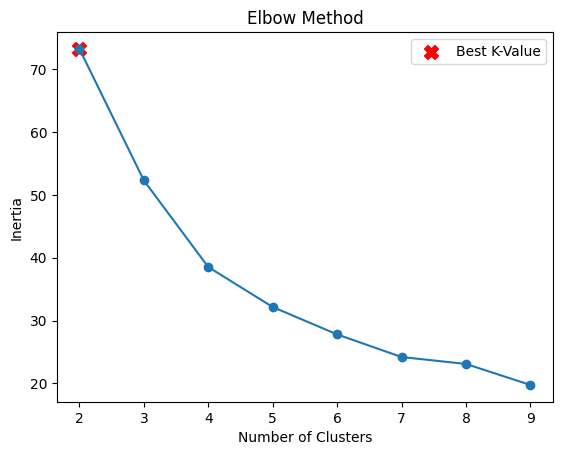

In [ ]:
#Parameters
inertia = []
best_k = 1
best_s_score = 0
best_inertia = 0

#Range for testing k in n_clusters
initial_k = 2
end_k = 10



def silhouette_model(param_data, param_labels):
        s_score = silhouette_score(param_data, param_labels)
        print(f'Silhouette Score of Model: {s_score:.4f}')



def silhouette_clusters(param_data, param_labels):
        sample_silhouette_values = silhouette_samples(param_data, param_labels)

        for cluster in np.unique(param_labels):
                cluster_mean = sample_silhouette_values[param_labels == cluster].mean()
                print(f"Silhouette Score of Cluster {cluster}: {cluster_mean:.4f}")



for k in range(initial_k, end_k):
        kmeans = KMeans(n_clusters=k, random_state=1)
        labels = kmeans.fit_predict(segment_college_data)
        s_score = silhouette_score(segment_college_data, labels)

        if s_score > best_s_score:
                best_s_score = s_score
                best_k = k

        print(f"Where k={k}, Silhouette Score: {s_score:.4f}")
        inertia.append(kmeans.inertia_)



#print(f'\nOptimal number of clusters k: {best_k}')
best_inertia = inertia[best_k - initial_k]



plt.plot(range(2,10), inertia, marker='o')
plt.scatter(best_k, best_inertia, marker='X', color='red', s=100, label='Best K-Value')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()

**Cluster Plot**

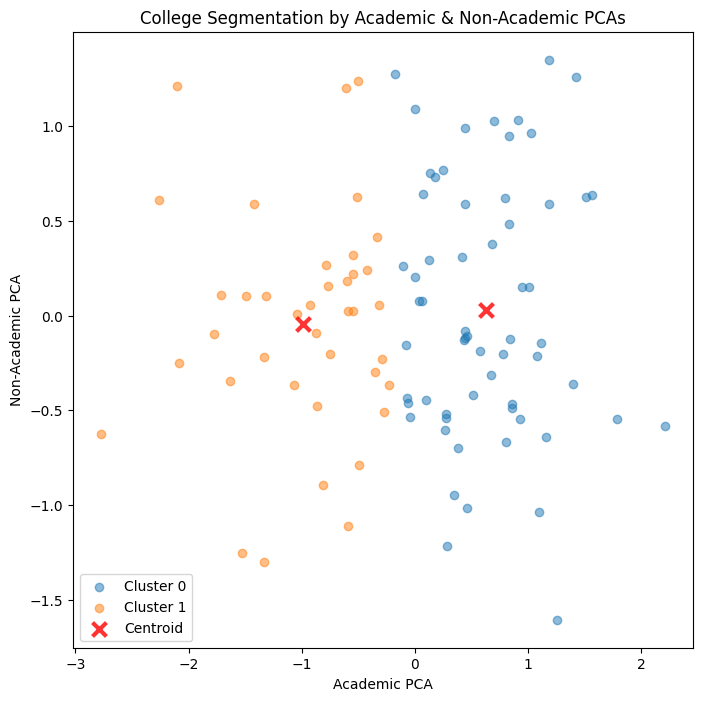

Cluster Proportions (%):
0    61.0
1    39.0
Name: proportion, dtype: float64
 
Silhouette Score of Model: 0.4896
 
Silhouette Score of Cluster 0: 0.4876
Silhouette Score of Cluster 1: 0.4928


In [ ]:
segment_college_axis = ['Academic_PCA', 'Non_Academic_PCA']
segment_column_name = 'College_Segment'


def kmeans_segment(param_clusters, param_data, param_axis, param_column_name='Column', param_describe=True, param_return=False):
    kmeans_model = KMeans(n_clusters=param_clusters, random_state=1)
    param_data[param_column_name] = kmeans_model.fit_predict(param_data)
    
    kmeans_plot(param_clusters, param_data, param_axis, kmeans_model)

    if(param_describe == True):
        cluster_distributions(kmeans_model)
        print(" ")

        silhouette_model(param_data, param_data[param_column_name])
        print(" ")

        silhouette_clusters(param_data, param_data[param_column_name])

    if(param_return == True):
        return param_data


#Determine % of samples in each cluster.
def cluster_distributions(param_model):
    cluster_counts = param_model.labels_
    cluster_distribution = pd.Series(cluster_counts).value_counts(normalize=True) * 100     #Turn it into a percentage.

    print("Cluster Proportions (%):")
    print(cluster_distribution.sort_index())



def kmeans_plot(param_clusters, param_data, param_axis, param_model):
    centroids = param_model.cluster_centers_

    plt.figure(figsize=(8,8))

    for cluster in range(param_clusters):
        cluster_points = param_data[param_model.labels_ == cluster]
        plt.scatter(cluster_points[param_axis[0]], cluster_points[param_axis[1]], alpha=0.5, label=f'Cluster {cluster}')

    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroid', alpha=0.8, linewidths=3, s=100)
    plt.xlabel('Academic PCA')
    plt.ylabel('Non-Academic PCA')
    plt.title('College Segmentation by Academic & Non-Academic PCAs')
    plt.legend()
    plt.show()



kmeans_segment(best_k, segment_college_data.copy(), segment_college_axis)

#### Interpretation of Silhouette Scores (for clustering): ####
- High silhouette (**close to 1**) - Samples assigned to cluster have a strong natural belonging to their group.
    - **Greater than 0.7** = Strong clustering.
    - **0.5 to 0.7** = Reasonable clustering.
    - **0.25 to 0.5** = Acceptable but weak clustering.
- Low silhouette (**close to 0**) - Ambiguous assignments. A lot of samples overlaping between decision boundaries.
- Negative silhouette (**< 0**) - High likelihood of misclassification of samples.

#### Breakdown of Results ####
- Best silhouette score where **n_clusters = 2**.
    - 2 clusters gives the best separation for the given data.
- Silhouette score of **0.39** at **n = 2**.
    - Generally acceptable threshold is **silhouette score > 0.5** 
        - Would suggest data has well defined segmented, spherical clusters - greater the value the greater the separation and compactness of data.
    - Threshold can be lowered depending on the data.
        - Data with weak structure will usually accept **silhouette score > 0.25**.
        - The data used has been identified to have weak structure, based on correlation matrix and PCA loadings.
    - Consider other segmentation models:
        - Support Vector Machines - Linear separation (hyperplane).
        - Gaussian Mixture Model - Elliptical clusters.
- Where **n_clusters = 2**.
    - Clear boundary line between two clusters using the horizontal axis.
        - Separation around **-0.1/2**.
        - Clear signs that academic metrics have the strongest influence in college requirements; for receiving a placement.
- Vertical axis underutilized.
    - Suggest low relevancy in clustering, where **n_cluster is 2**.
    - May suggest non-academic features contribute less variance overall.
    - Reduces overall interpretive value of the model as it does not account for non-academic values.
    - Consider increasing the number of clusters for improved interpretability & representation.
        - Try **n_clusters = 3** for improved interpretability at the cost of a lower silhouette score (weaker cluster shape/potential overlapp).

- **Validation:**
    - Cluster proportions:
        - **61 of 100** - Colleges with high academic PCA (**Cluster 0**).
        - **39 of 100** - Colleges with low academic PCA (**Cluster 1**).
        - **Cluster 0** is **≈50%** larger than **Cluster 1**.
        - A decision boundary line at around **Academic_PCA ≈ 0**.
    - Moderate cluster performance for a **n = 2** model - Silhouette score of **0.49**.
        - Silhouette score for both clusters **≈ 0.49**.
            - Both segments have a centroid around **Non_Academic_PCA = 0**.
            - Similar s-scores are a symptom of overlap between segments with shared characteristics.
                - Overall balanced but limited separation of colleges.
                - Both segments have an overlap at **Academic_PCA = 0** where samples are most concentrated.
                - Colleges closer to **Academic_PCA = 0** are harder to classify between the two segments due to possessing characteristics of both segments; making classification ambiguous.
        - Model classification of samples is reasonable for an initial segmentation, but has plenty room for improvement in regards to actionable insights.
            - Samples may have ambiguous classification - samples near the origin in particular are not well separated using KMeans (**n = 2**).
            - Try increasing the number of clusters.

#### 5.1.1 - KMeans Retest w/ 3 Clusters

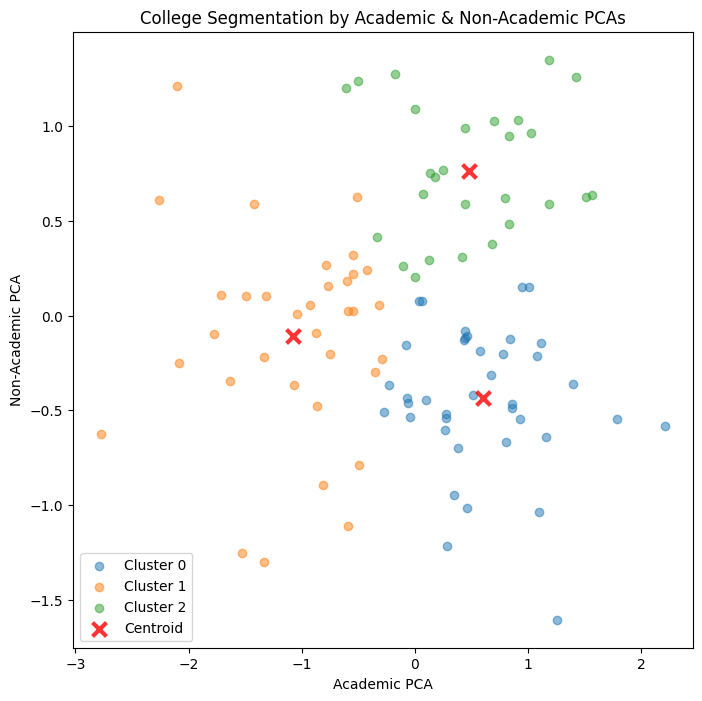

Cluster Proportions (%):
0    39.0
1    34.0
2    27.0
Name: proportion, dtype: float64
 
Silhouette Score of Model: 0.5584
 
Silhouette Score of Cluster 0: 0.6011
Silhouette Score of Cluster 1: 0.4943
Silhouette Score of Cluster 2: 0.5776


In [ ]:
college_segments = kmeans_segment(3, segment_college_data.copy(), segment_college_axis, segment_column_name, True, True)

#### Breakdown of Results ####
- Silhouette score of **0.37**.
    - Generally acceptable threshold is **silhouette score > 0.5** 
        - Would suggest data has well defined segmented, spherical clusters - greater the value the greater the separation and compactness of data.
    - Threshold can be lowered depending on the data.
        - Data with weak structure will usually accept **silhouette score > 0.25**.
        - The data used has been identified to have weak structure, based on correlation matrix and PCA loadings.
        - Where n_clusters = 2, **silhouette score = 0.393**.
            - Marginal difference of silhouette score between **n_clusters of 2 & 3** (**Δ = 0.02**).
                - Negligble difference between s_score, but **k=3** gives better interpretability & more meaningful segmentation.
        - Therefore **n_clusters = 3** is acceptable for KMeans clustering.
            - However, there may be better models for segmentation.
                - Support Vector Machine (SVM) - Separation of data by a hyperplane for readable classification.
                - Gaussian Mixture Model (GMM) - Elliptical segmenting of data for better handling of overlapping structure.
                - Hierarchial Clustering - For segmentation of data that doesn't follow a spherical/elliptical structure.
- Where **n_clusters = 3**.
    - Shape of segments is not spherical.
        - There may be better suited models for segmenting this set of data.
        - Some overlapp between clusters - Cluster 0 in particular.
            - Suggests similar/shared requirements - Borderline cases with segmentation; varying on subtle differences of placement strategies.
    - Retains the previous separation for academic PCA.
        - Absolute variance of transformed axis:
            - Academic_Axis variance = **0.9466**.
            - Non_Academic_Axis variance = **0.4204**
        - Suggests the academic axis remains the dominant factor in driving the spread of college placements; due to larger absolute variance (**~70% vs 30% split**).
    - Original cluster 1 (right-half) is clearly separated by a vertical axis; forming 2 sub-clusters.
        - Suggests further separation of high academic colleges by non-academic values.
            - A secondary but meaningful role.
    - Centroids positioned:
        - Cluster 0 - Bottom right.
        - Cluster 1 - Mid left.
        - Cluster 2 - Top right.

- **Validation:**
    - Cluster Proportions:
        - **Cluster 0** - Academics-oriented colleges (**≈ 39%**).
            - Strong academic requirements, but limited emphasis of non-academic development - Traditional or exam-driven institutions.
        - **Cluster 1** - Non-Academic focused colleges (**≈ 34%**).
            - Greater emphasis of non-academic skills, with weaker academic requirements - Likely vocational training centres, or apprenticeship-focused colleges.
        - **Cluster 2** - Well-Rounded colleges (**≈ 27% of colleges**).
            - High in both academics & non-academics - Prestigious or highly competitive colleges that expect strengths in both dimensions.
        - Decision boundary of all 3 clusters converges at origin (**0,0**) where most colleges are concentrated at.
        - Colleges are more evenly spread between segments than **n = 2**.
            - Difference of proportion between segments does not exceed **40%**.
            - Segments are more balanced, but may lead to more overlap thus poorer separation.
            - Decision boundaries of segments likely border each other or even overlap.
    - Moderate cluster performance for a **n = 3** model - Silhouette score of **0.56**.
        - A higher silhouette score for the model compared to **n = 2** (**0.49**).
            - **n = 3** is more suitable than **n = 2** for KMeans clustering in regards to segmentation.
        - Cluster silhouette scores:
            - **Cluster 0** - **0.60**
            - **Cluster 1** - **0.49**
            - **Cluster 2** - **0.58**
        - Moderate segmentation of all 3 clusters.
            - **Cluster 1** has the worst s-score of the three.
                - Implies weak separation compared to other clusters.
                - Occupies the entire left half of the plot.
                - Weak s-score is a symptom of being the cluster with the most visually dispersed colleges 
                    - Possesses a larger decision boundary than the other two segments.
                    - Therefore a greater degree of overlap between this and its two neighbours, making classification more ambiguous.
            - **Cluster 0** & **Cluster 2** have stronger cohesion.
                - Similar scores likely suggests a relationship between the two clusters - both are classified into high academic PCA.
                - Both clusters share the right half of the plot - colleges on the right half will be categorised as one of the two.
                    - Colleges situated in between will have more ambiguous classification hence similar scores.
                - **Cluster 0** has more colleges that are also dispersed *away* from **Cluster 2** hence a better silhouette score; as they have a greater sense of belonging.
            - Colleges are concentrated towards origin therefore an overlap between the three clusters exist at the origin.
                - This obscures the classification of colleges.
        - Visible linear-like separation of clusters between all 3 segments despite being a spherical clustering algorithm - espeically towards origin.
            - Indicates weak separation for this particular model despite an increase in clusters.
            - This model may not be suitable for the data.
                - Try different models and compare results.

    
</br>

**Next Steps:** Other segmentation models will be used to test the data to determine the most suitable method for segmenting colleges.

### 5.2 - Gaussian Mixture Model

Cluster Proportions (%):
0    53.0
1    25.0
2    22.0
Name: proportion, dtype: float64
 
Silhouette Score of Model: 0.3363
 
Silhouette Score of Cluster 0: 0.2846
Silhouette Score of Cluster 1: 0.3817
Silhouette Score of Cluster 2: 0.4093


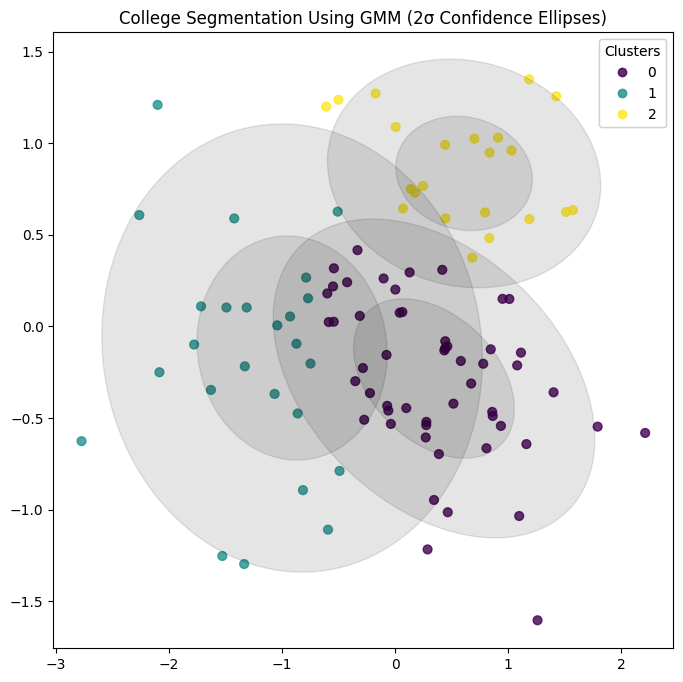

In [ ]:
gmm_model = GaussianMixture(n_components=3, covariance_type='full', random_state=1).fit(segment_college_data)
gmm_predict = gmm_model.labels_ = gmm_model.predict(segment_college_data)   #'labels_' syntax needed for cluster_distributions.



#Code from Python Data Science Handbook.
def gmm_ellipse(param_position, param_covariance, ax=None, **kwargs):

    """Draw an ellipse with a given position and covariance"""
    if ax is None:
        ax = plt.gca()

    if param_covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(param_covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)

    else:
        angle = 0
        width, height = 2 * np.sqrt(param_covariance)

    # Draw ellipses for 1σ & 2σ.
    for nsig in range(1, 3):
        ax.add_patch(Ellipse(
            xy=(param_position[0], param_position[1]),   #Ensure (x,y) structure.
            width=nsig * width,
            height=nsig * height,
            angle=angle,
            **kwargs
        ))



cluster_distributions(gmm_model)
print(" ")
silhouette_model(segment_college_data, gmm_predict)
print(" ")
silhouette_clusters(segment_college_data, gmm_predict)



plt.figure(figsize=(8,8))
gmm_scatter = plt.scatter(segment_college_data['Academic_PCA'], 
            segment_college_data['Non_Academic_PCA'], 
            c=gmm_predict, s=40, cmap='viridis', alpha=0.8)

for pos, covar in zip(gmm_model.means_, gmm_model.covariances_):
    gmm_ellipse(pos, covar, alpha=0.1, color='black')

gmm_legend = plt.legend(*gmm_scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(gmm_legend)

plt.title('College Segmentation Using GMM (2σ Confidence Ellipses)')
plt.show()

#### Breakdown of Results: ####
- Where **n_clusters = 3**, with **2σ ellipses**.
    - Assume 1σ a region with high confidence (denser probability mass), and 2σ to be a broader region of uncertainty in cluster membership.
    - Overlap is present between the 3 clusters: Where **x = 0 to 1**, and **y = 0 to 0.5**.
        - Overlap is between 2σ ellipses.
        - Colleges within this space can potentially be assigned to any of the three clusters, according to this GMM model.
            - Suggests that qualities of all 3 segments are present within these colleges, and that their assigned cluster, are likely borderline cases based on subtle geometric assumptions.
    - Overlap between cluster 0 and 1, at 1σ ellipse.
        - Indicates high uncertainty between membership of cluster 0 and 1 in that space.
            - Carries strong characteristics of both clusters, making it hard to distinguish between the two.
            - Suggests poor separation of clusters using this model, for these two particular clusters.
                - Try using non-convex segmented models.
    - 2σ for cluster 1 (left-side) covers a large portion of the plot.
        - Suggests high uncertainty of assigning colleges to this segment.
            - This cluster assumes low academic performance, *but* varying non-academic performance (**y = -1.5 to 1.5**).
                - 2σ reflects the large spread of non-academic performance hence greater uncertainty in categorising by segment.
                    - Cluster is likely heterogeneous - Potentially contains distinct subgroups of colleges, but were merged into a single cluster due to cluster or model limitations.
                    - Consider spliting this segment into low and high non-academic performance, via more clusters (**n_cluster = 4**).
                    - Alternatively try another model to see if it is more suitable for naturally segmenting the data.
    - Heavy overlap between the three clusters.
        - Reinforces the assumption that the data is not suitable for convex clusters.
            - Consider other models:
                - Hierarchical Clustering - Captures nested structures.
                - DBSCAN - Captures irregular shapes.
                - SVM - Discriminitive classification of high-dimension data using clear margins/hyperplanes when clear segments are available.

- **Validation:**
    - Cluster Proportions:
        - **Cluster 0** - Academics-oriented colleges (**≈ 53%**).
        - **Cluster 1** - Non-Academics focused colleges (**≈ 25%**).
        - **Cluster 2** - Well-rounded colleges (**≈ 22%**).
        - **2σ ellipses** converge at origin **(0,0)** for all three clusters.
        - **1σ ellipses** for **Cluster 0** & **1** at origin.
        - Cluster proportions of **Cluster 0** is double that of **1** and **2**.
            - GMM has determined that most samples concentrated at origin, have a higher probability of being in **Cluster 0** than the other two clusters.
    - Moderate cluster performance for a **n = 3** model - Silhouette score of **0.33**.
        - Cluster silhouette scores:
            - **Cluster 0** - **0.28**
            - **Cluster 1** - **0.38**
            - **Cluster 2** - **0.41**
        - Moderate segmentation across all three clusters.
            - **Cluster 0** has lowest s-score.
                - Largely influenced by colleges at the origin, which were assigned to this cluster - These colleges have the greatest overlap, therefore the greatest assignment uncertainty.
        - Silhouette scores are substantially worse than the KMeans model.
            - GMM model uses soft probabilistic assignments, whereas KMeans uses hard partitional assignments based on mathematical assumptions.
                - Although visually similar, both models handle internal logic differently.
            - S-score is a hard assignment validation method, thus favouring KMeans, while penalising GMM due to different model philosophies.
            - GMM is a more adaptable model which can lead to overfitting especially for small or noisy datasets.
                - Large overlapping ellipses at origin which is captured in the probability assignments.
            - The poor score for GMM doesn’t necessarily imply poor separation, but mismatched validation.
                - It can represent a more realistic, less biased viewpoint.
        - Both GMM and KMeans have shown poor separation of colleges at the origin - Try a different model.
</br>

**Next Steps:** Try other segmentation models, that do not use convex clustering. Start with DBSCAN, to validate whether more clearer and more natural segmentations emerge.

### 5.3 - DBSCAN

**K-distance Graph**
- Determine EPS value based on 'min_samples'.

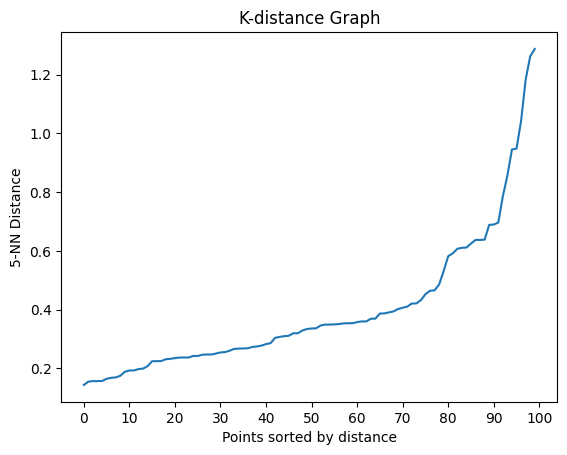

In [ ]:
min_samples = 5 #Number of samples nearby, for a point to be considered a core point in data. Default is 5.


#Generate a NN model, and return distances.
def k_distance_model(param_samples, param_data):

    neighbour_model =  NearestNeighbors(n_neighbors=param_samples).fit(param_data)
    neighbour_distances, neighbour_indices = neighbour_model.kneighbors(param_data)

    neighbour_distances = np.sort(neighbour_distances[:, -1])
    return neighbour_distances


#Plot a basic K-distance graph using minimum samples and neighbour distances.
def k_distance_plot(param_samples, param_distances):

    plt.plot(param_distances)
    plt.xticks(np.arange(min(param_distances.astype(np.int64)), len(param_distances)+1, 10)) # Set the increments of the axis in intervals of 10, starting with the minimum integer.
    plt.ylabel(f'{param_samples}-NN Distance')
    plt.xlabel("Points sorted by distance")
    plt.title("K-distance Graph")


#Plot a k-distance graph to estimate EPS using a basic k-distance graph and elbow point estimation.
def k_distance_eps(param_samples, param_distances, param_estimate):

    k_distance_plot(param_samples, param_distances)

    eps_estimate = round(param_distances[param_estimate], 4)

    plt.axvline(param_estimate, color='red', alpha=0.5, label='Elbow Point')
    plt.axhline(eps_estimate, color='green', alpha=0.5, label=f'eps ≈ {eps_estimate}')
    plt.legend()
    plt.show()

    return eps_estimate



neighbour_distances = k_distance_model(min_samples, segment_college_data)
k_distance_plot(min_samples, neighbour_distances)

#### 5.3.1 - Calculating Parameters

**Estimate EPS** 
- Where elbow point is ≈ 80 points.

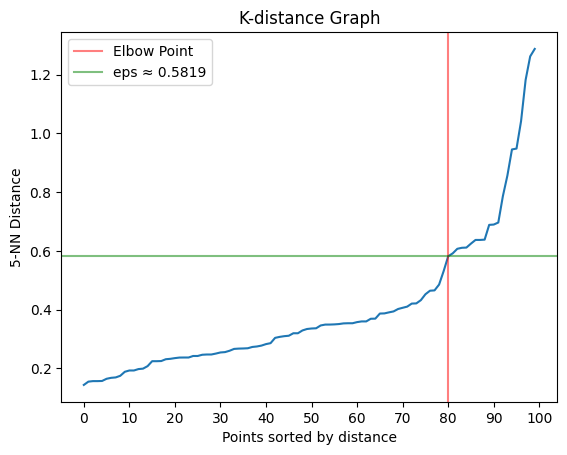

In [ ]:
eps_estimate = k_distance_eps(min_samples, neighbour_distances, 80)

**DBSCAN Model Suitability Test**
- Checking to see if current model is suitable based on preliminary findings.
- *Consider hyperparameter tuning if necessary (e.g. model produced only 1 cluster).*

In [ ]:
def db_suitability(param_eps, param_sample, param_data):
    db_model = DBSCAN(eps=param_eps, min_samples=param_sample).fit(param_data)
    db_labels = db_model.labels_

    db_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    db_noise = list(db_labels).count(-1)

    print('Estimated number of clusters: %d' % db_clusters)
    print('Estimated number of noise points: %d' % db_noise)



db_suitability(eps_estimate, min_samples, segment_college_data)

Estimated number of clusters: 1
Estimated number of noise points: 8


#### Breakdown of Results: ####
- Where min_sample (minimum number of samples needed to be considered a cluster) = **5**.
    - EPS (the maximum distance for two sample to be considered neighbours) = **0.5819**.
    - Assumed clusters for DBSCAN model = **1**.
    - Assumed points that do not belong in any cluster = **8**.
- The DBSCAN assumes (*almost*) every sample is a neighbour, and considers it **one** giant cluster.
    - EPS of **0.5819** is *large* for our particular dataset.
        - x axis range = -3 to 2.
            - EPS takes up **~12%** of axis span.
        - y axis range = -2 to 1.5.
            - EPS takes up **~16%** of axis span.
        - We have **100** samples within the graph.
            - EPS is considered large based on the relative density and spread of a compact set of data, leading to most samples being registered in the same neighbourhood.
- The intent of DBSCAN is to segment colleges based on density.
    - Goal is not achieved as no segmentation has occured.
    - Consider that DBSCAN is not suitable for this data.
        - Data has not shown to exhibit strong density fluctuations.
        - Colleges are too compact for DBSCAN to detect natural density-based clusters.
    - Try hyperparameter (samples & eps) tuning to retest the suitability of the model.

#### 5.3.2 - DBSCAN Retest w/ Hyperparameter Tuning
- Where min_samples = 3

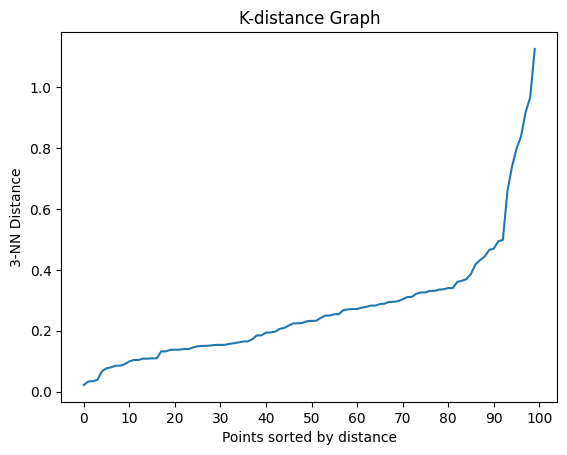

In [ ]:
min_samples = 3

neighbour_distances = k_distance_model(min_samples, segment_college_data)
k_distance_plot(min_samples, neighbour_distances)

**Estimaate EPS**
- Where elbow point is ≈ 85 points.

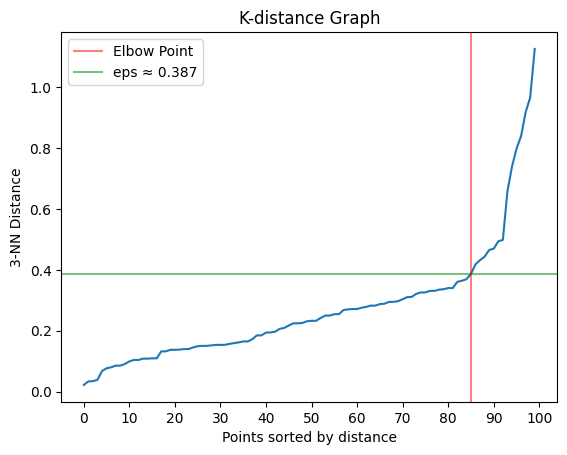

In [ ]:
eps_estimate = k_distance_eps(min_samples, neighbour_distances, 85)

**DBSCAN Model Suitability Test**

In [ ]:
db_suitability(eps_estimate, min_samples, segment_college_data)

Estimated number of clusters: 1
Estimated number of noise points: 12


#### Breakdown of Results: ####
- Where min_sample (minimum number of samples needed to be considered a cluster) = **3**.
    - EPS (the maximum distance for two sample to be considered neighbours) = **0.387**.
    - Assumed clusters for DBSCAN model = **1**.
    - Assumed points that do not belong in any cluster = **12**.
- The DBSCAN assumes (*almost*) every sample is a neighbour, and considers it **one** giant cluster.
    - Min_samples of retest is smaller than initial test (**3 < 5**).
    - EPS of retest is smaller than initial test (**0.387 < 0.5819**).
    - EPS of **0.387** is still too *large* for our particular dataset.
        - x axis range = -3 to 2.
            - EPS takes up **~8%** of axis span.
        - y axis range = -2 to 1.5.
            - EPS takes up **~11%** of axis span.
        - We have **100** samples within the graph.
            - EPS is considered large based on the relative density and spread of a compact set of data, leading to most samples being registered in the same neighbourhood.
- The intent of DBSCAN is to segment colleges based on density.
    - Goal is not achieved as no segmentation has occured.
    - Consider that DBSCAN is not suitable for this data.
        - Data has not shown to exhibit strong density fluctuations.
        - Colleges are too compact for DBSCAN to detect natural density-based clusters.
- Where both min_samples & EPS were smaller than the initial test.
    - Number of identified density-base clusters remain at **1**.
        - Safe to assume that the density and spread of data is not suitable for DBSCAN, and other methods should be employed instead.
            - Try Hierarchical clustering to capture nested logic.

### 5.4 - Hierarchical Clustering
- Start by mapping logical clusters using a *dendrogram* to test suitability.
- If clear defined clusters/branches are formed proceed with hierarchical clustering.
    - Ideally show have a tall & wide (100 samples) structure, rather than a flat one.

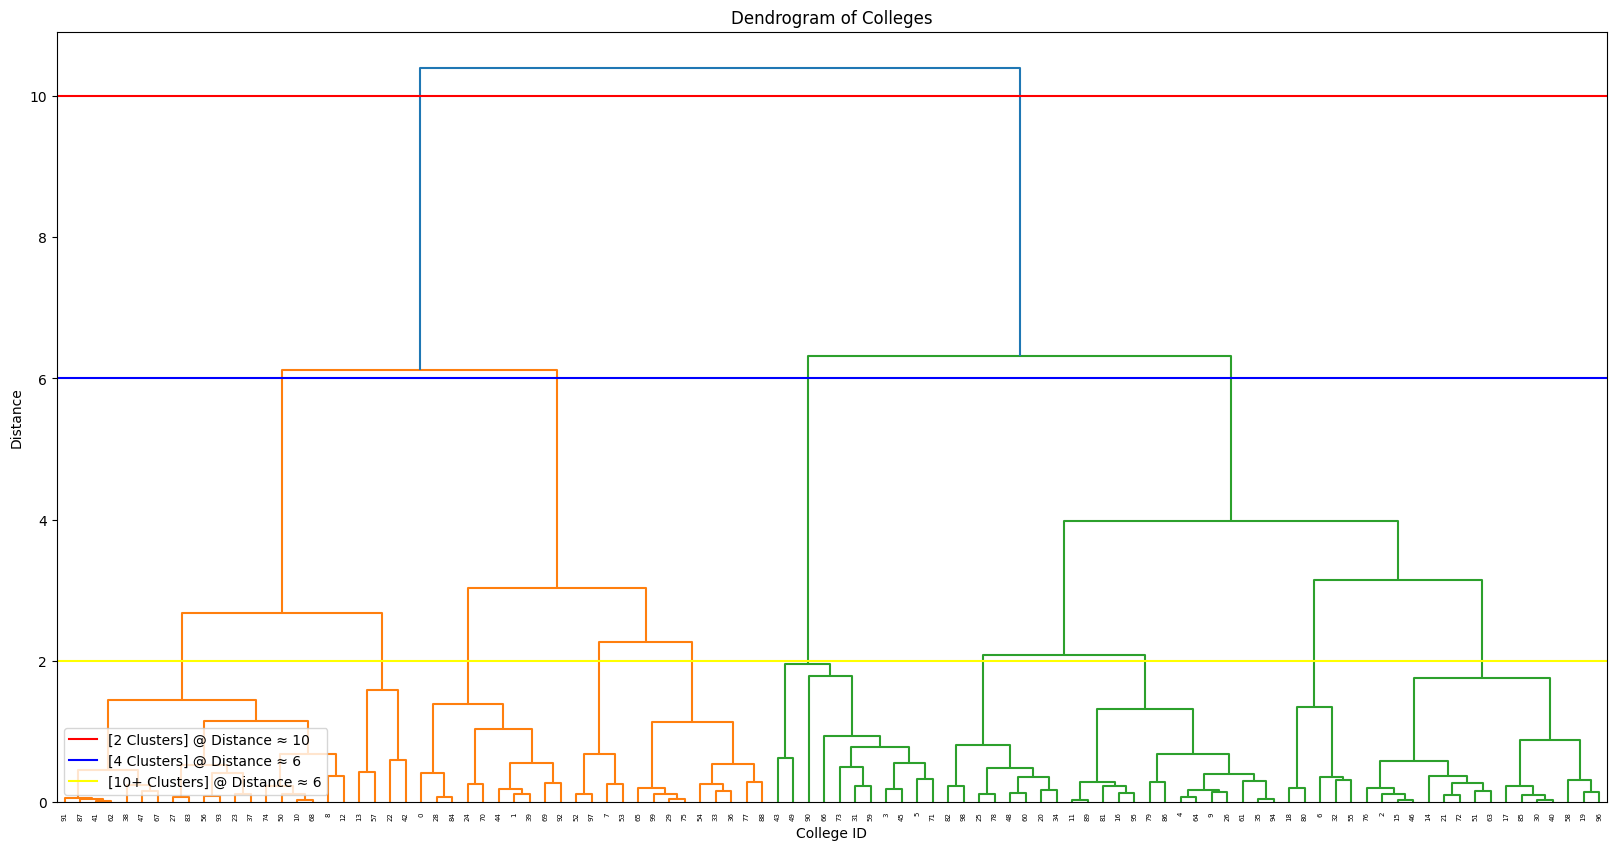

In [ ]:
college_linkage = linkage(segment_college_data,  method='ward',  metric='euclidean')

plt.figure(figsize=(20,10))

dendrogram(college_linkage)

plt.title('Dendrogram of Colleges')
plt.xlabel('College ID')
plt.ylabel('Distance')
plt.axhline(10, label='[2 Clusters] @ Distance ≈ 10', color='red')
plt.axhline(6, label='[4 Clusters] @ Distance ≈ 6', color='blue')
plt.axhline(2, label='[10+ Clusters] @ Distance ≈ 6', color='yellow')
plt.legend()
plt.show()

#### Breakdown of Results: ####
- Dendrogram:
    - Visual representation of natural groupings between data.
    - A tree structure, where each branch represents a separate cluster.
    - x-axis represents the data samples (100 colleges in our data).
    - y-axis represents when samples were merged: *low = very similar, high = more different*.
        - Low values suggest early groupings of between similar sets of colleges.
        - High values suggest large clusters formed based of similar characteristics.
        - The higher the y-value the broader & more lenient the conditions for natural groupings of data.
        - The lower the y-value the more distinct & specific the conditions are for natural groupings between data.
- At **y = 10** there are **2** distinct clusters.
    - Academic vs non-academic colleges.
    - Broad general groupings, but clear understanding of separation 
    - Less complexity involved, meaning insights are simpler to interpret and refine into actions.
- At **y = 6** there are **4** distinct clusters.
    - High-low distinctions between academic and non-academic colleges.
    - More insights can be drawn based on clear distinction of high and low tiers of performance (both academic and non-academics).
    - Clear targetted action groups and fine tuning of ```Student_Score```.
- At **y = 2** there are numermous clusters.
    - Subgroups of the **4** clusters, based on distinct characteristics.
    - Not suitable for practical interpretation as it would be too time consuming, and potential overfitting of results.
    - Less actionable due to excessive micro-segmentation.
- **Based on the findings:**
    - Hierarchical clustering is worth further exploration.
        - There are clear defined natural groupings of data both in the upper and lower layers.
        - A *tall* tree model.
            - Implies complex overarching hierarchical structure in the data, making this model suitable for this data.
            - Implies nested relationships present in the data.
    - Model suggests that it is worth exploring **4** clusters instead of just **3**.
        - Previous assumptions of KMeans and GMM suggested **3** clusters.
        - Hierarchical clustering supports the theory of splitting *cluster 1* into high and low non-academic performance found in DBSCAN.
        - Consider previous models but where **n_cluster = 4** for further insights.
    - Clear natural groupings of data at the upper layer.
        - **2** & **4** natural clusters at a broader level.
        - Below the natural clusters are numerous distinct subgroups.
        - Using **4** clusters instead of **2** allows for more granular exploration of data, at the cost of more time.

#### 5.4.1 - Hierarchical Clustering w/ 4 Clusters

Cluster Proportions (%):
0    43.0
1    23.0
2    11.0
3    23.0
Name: proportion, dtype: float64
 
Silhouette Score of Model: 0.3374
 
Silhouette Score of Cluster 0: 0.2274
Silhouette Score of Cluster 1: 0.3515
Silhouette Score of Cluster 2: 0.4737
Silhouette Score of Cluster 3: 0.4636


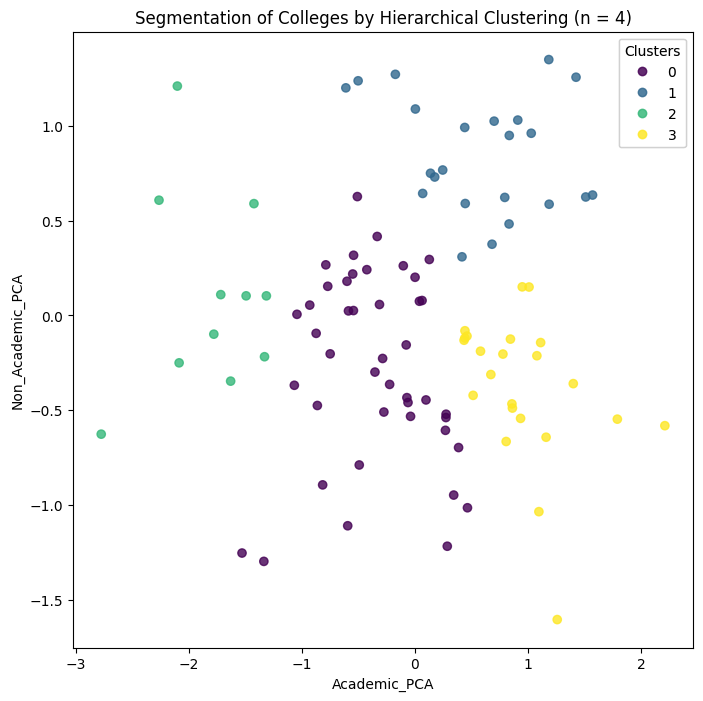

In [ ]:
def hierarchical_cluster_plot(param_cluster, param_data, param_ax=None, param_describe=True, param_return=False):
    hc_model = AgglomerativeClustering(n_clusters=param_cluster, linkage='ward')
    hc_labels = hc_model.fit_predict(param_data)

    if param_ax is None:
        fig, param_ax = plt.subplots(figsize=(8,8))

    scatter = param_ax.scatter(param_data.iloc[:, 0], param_data.iloc[:, 1], c=hc_labels, alpha=0.8)

    hc_legend = param_ax.legend(*scatter.legend_elements(), title="Clusters")
    param_ax.add_artist(hc_legend)

    param_ax.set_title(f'Segmentation of Colleges by Hierarchical Clustering (n = {param_cluster})')
    param_ax.set_xlabel(param_data.columns[0])
    param_ax.set_ylabel(param_data.columns[1])

    if(param_describe == True):
        cluster_distributions(hc_model)
        print(" ")

        silhouette_model(param_data, hc_labels)
        print(" ")

        silhouette_clusters(param_data, hc_labels)

    if(param_return == True):
        return hc_labels




hierarchical_cluster_plot(4, segment_college_data)

**Side by Side Comparison where n = 3 & n = 4**

Where n = 3 

Cluster Proportions (%):
0    46.0
1    43.0
2    11.0
Name: proportion, dtype: float64
 
Silhouette Score of Model: 0.3077
 
Silhouette Score of Cluster 0: 0.2574
Silhouette Score of Cluster 1: 0.3191
Silhouette Score of Cluster 2: 0.4737

Where n = 4 

Cluster Proportions (%):
0    43.0
1    23.0
2    11.0
3    23.0
Name: proportion, dtype: float64
 
Silhouette Score of Model: 0.3374
 
Silhouette Score of Cluster 0: 0.2274
Silhouette Score of Cluster 1: 0.3515
Silhouette Score of Cluster 2: 0.4737
Silhouette Score of Cluster 3: 0.4636


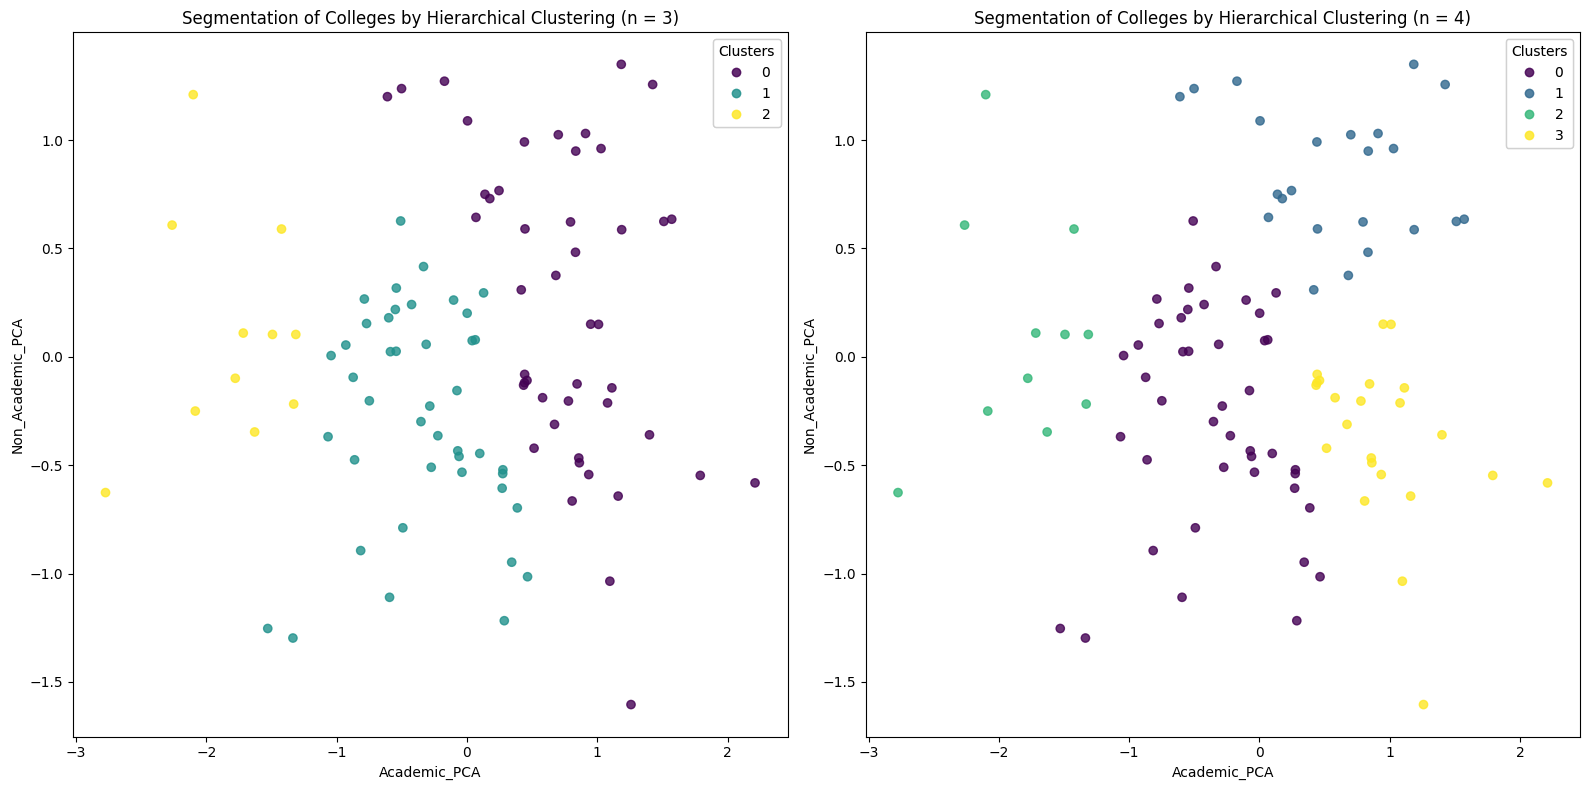

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

print("Where n = 3 \n")
hierarchical_cluster_plot(3, segment_college_data, param_ax=axes[0])
print("\nWhere n = 4 \n")
hierarchical_cluster_plot(4, segment_college_data, param_ax=axes[1])

plt.tight_layout()
plt.show()

#### Breakdown of Results ####
- Where **n = 3** (fig 1):
    - Colleges are segmented primarily by *Academic_PCA* axis - into low, and high.
        - Low *Academic_PCA* can be further segmented by *Non_Academic_PCA*:
            - Moderate-high *Non_Academic_PCA* & low *Academic_PCA*.
            - Low-Moderate *Non_Academic_PCA* & Moderate-low *Academic_PCA*.
    - **Cluster 0 - Broad Academic Segment**:
        - **46** out of **100** samples.
            - The largest cluster.
        - Unclear decision boundary - wide spread of samples in comparison to other clusters spanning both academic and non-academics.
            - Cluster occupies a large portion of *Academic_PCA* range, and spans the entire length of *Non_Academic_PCA*.
            - A broad cluster likely composed of multiple sub-groups.
            - Potential to be futher segmented based on sub-groups (e.g. prestigious & research colleges).
        - Based on the spread along the axes - likely represents high-end/presitigious colleges.
            - Strong academic requirements as a baseline.
            - Has a spectrum of non-academic requirements - reinforces the fact that sub-groups exist in this cluster.
    - **Cluster 1 - Balanced Segment**:
        - **43** out of **100** samples.
            - A large cluster following shortly behind **cluster 0**.
        - Spread of samples is more compact towards the center where both axes are zero.
            - Strong natural relationships between data - harder to segment further without micro-segmentation.
                - Micro-segmentation not recommended due to less actionable insights from overfitting results.
        - Represents colleges with more flexible/moderate expectations for placements for both academics and non-academics.
            - A spread of academic and non-academic requirements, with a concentration at the center of both axes.
    - **Cluster 2 - Vocational Segment**:
        - **11** out of **100** samples.
            - Smallest cluster by a factor of **4**.
        - Relatively wide spread of samples focused around the mid-top left.
            - Samples are loosely grouped together and can probably be further segmented to some degree.
            - Low number of samples being further segmented is unlikely to give meaningful actionable insights, so not recommended.
        - A more niche cluster focused more on non-academics.
            - Likely represents vocational or practical-skill-oriented colleges.
            - All samples have low academic requirements, and is likely a sub-group of **cluster 1**.
                - Segmented by *Academic_PCA*.

- Where **n = 4** (fig 2):
    - Both Balanced and Vocational segment remain unchanged, however Broad Academic segment (from **n = 3**) is split into two.
        - Both high *Academic_PCA* & high *Non_Academic_PCA*.
        - High *Academic_PCA* & Low *Non_Academic_PCA*.
        - Split occurs around a horizontal plane at **0.2** *Non_Academic_PCA* axis transforming it into two specific groups.
    - **Cluster 0 - Balanced Segment**:
        - Remains unchanged.
        - Continues to represent colleges with moderate academic and non-academic profiles.
        - The cluster remains compact and well-defined, demonstrating strong natural grouping.
    - **Cluster 1 - Prestigious Segment**:
        - **23** out of **100** samples.
            - A clean **50/50** split of the original 46 in **Broad Academic Segment**.
            - Occupies upper-right quadrant.
        - Spread of samples concentrated towards the top-right of the hierarchical cluster plot.
            - Stronger natural relationships between samples as opposed to the former cluster.
            - Unlikely to be further segmented without micro-segmentation.
        - Represents prestigious colleges, having expectations of strong academic and non-academic abilities for placements.
    - **Cluster 2 - Vocational Segment**:
        - Remains unchanged.
        - Characterized by low Academic_PCA and moderate-to-high Non_Academic_PCA.
        - Represents vocational or skills-focused colleges with more practical, less academically demanding requirements.
    - **Cluster 3 - Academic-Focused Segment**:
        - **23** out of **100** samples.
            - A clean 50/50 split of the original 46 in **Broad Academic Segment**.
            - Occupies lower-right quadrant.
        - Samples are more dispersed as opposed to **cluster 1**.
            - Suggests possible segmentation, however the low number of samples makes it a poor choice with the current data.
                - Not enough samples to draw meaningful actionable insights if further segmented.
        - Has low non-academic expectations, being more academic focused.
            - Likely represents research-intensive/oriented colleges.

- **Overview:**
    - An strong additional natural subdivision exists in **Broad Academic Segment** (**n = 3**) to justify an additional segment (**n = 4**).
        - A clean **50/50** split along the non-academic axis to form: **Prestigious Segment** (high academic & non-academic) & **Academic-Focused Segment** (high academic, low non-academic).
    - Strong natural grouping present in **Balanced Segment** near origin (0,0).
        - A few samples below **-0.75** *Non_Academic_PCA* are disperesed, not consistant with the natural sub-group.
            - Potential for a fifth segment - however, dendrogram suggests that there will be greater dissimilarity at **n = 5**.
                - May lead to overfitting/diminishing interpretive value.
    - Samples in **Vocational Segment** are loosely grouped.
        - Enough samples to be considered its own segment.
        - Sample size is not large enough or cohesive enough to justify further sub-divisions.
    - Notable contrast in cluster logic between hierarchical clusters and other cluster plots (*KMeans, GMM, & DBSCAN*).
        - *Non_Academic_PCA* is utilised for clustering where **n = 4** in hierarchical clustering.
        - *Non_Academic_PCA* is utilised for clustering where **n = 3** in other clustering.
        - Hierarchical clustering suggests that *Academic_PCA* is a stronger determinant for segmentation than the other clustering algorithms imply.

- **Validation:**
    - Silhouette scores used to measure appropriateness of sample assignments to clusters.
        - Assesses how well each samples fits into their assigned cluster as opposed to other clusters.
        - Not to be confused with cluster cohesiveness.
    - Where **n = 3 silhouette = 0.31**:
        - *Weak but acceptable* silhouette score - Separation of samples into clusters has ambiguity.
            - *Reasonable* clustering for **cluster 2** - An isolated cluster with a clear identity.
            - *Poor* clustering for **cluster 0 & 1** - Decision boundary lies where most samples are concentrated causing subtle cluster assignment discrepencies.
    - Where **n = 4 silhouette = 0.34**:
        - *Weak but acceptable* silhouette score - Stronger score than **n=3**, indicates **n=4** is a more suitable structure for the data.
            - *Reasonable* clustering for **cluster 2 & 3** - Both clusters are stable due to being on the opposite ends of the axes, samples with extreme values (low or high) have a clear sense of belonging.
            - *Poor* clustering for **cluster 0 & 1** - Decision boundaries compete for samples where they are most concentrated (around the origin).
    - Overall an acceptable but imperfect model - Worth noting that is ambiguity between cluster assignments especially for **cluster 0** (**Balanced**) and **cluster 1** (**Prestigious**).
        - Not an issue with the model, but reflects natural overlap between colleges with similar profiles.
        - **n = 4** has been shown to have the best interprative structure for hierarchical clustering.
    

### 5.5 - Evaluating Clustering Models

| Model | Type | Clusters | Overall </br> Silhouette | Key Observations | Strengths | Weaknesses | Interpretability |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  KMeans  |  Hard (Partitional)  |  **2**  |  **0.49**  |  Clear binary separation across **Academic_PCA ≈ 0**  |  Clean clusters </br> Easy to interpret  |  Under-utilised Y-axis (**Non_Academic_PCA**) </br> Misses subgroups  |  **Moderate** - Overly broad segmentation  |
|  KMeans  |  Hard (Partitional)  |  **3**  |  **0.56**  |  Distinct </br> Balanced cluster proportions  |  Intuitive segments </br> Easy to interpret </br>  Best silhouette score  |  Weaker separation at origin </br> Visual linear-separation in a spherical clustering model  |  **High** - Clean & stake-holder friendly  |
|  GMM  |  Soft (Probabilistic)  |  **3**   |  **0.33**  |  Probabilistic overlap at origin </br> **Cluster 0** (high academic, low non-academic) distinctly larger than other clusters  |  Realistic </br> Captures uncertainty (probabilistic model)  |  Mismatched validation (weaker silhouette)  |  **Moderate** - More realistic but less decisive  |
|  DBSCAN  |  Density-based  |   **1**   |  N/A  |  Only model to suggest **n = 1** - No distinct clusters </br> Re-test when there are more samples  |  Captures patterns via density over shape </br> Good for data with unique patterns  |  Not suitable for current data </br> Poor compatability with small compact datasets </br> Current model results are not insightful  |  **Very low** - Unusable for current dataset  |
|  Hierarchical  |  Agglomerative (Tree)  |  **3**   |  **0.31**  |  Broad natural groupings </br> Visual difference in clusters compared to KMeans and GMM  |  Reveals structural relationships  |  Ambiguity in separation near origin  |  **High** - Broad natural clusters  |
|  Hierarchical  |  Agglomerative (Tree)  |  **4**   |  **0.34**  |  Distinct sub-clusters from a larger cluster  |  Captures academic & non-academic granularity </br> Identifies nested relationships in data </br> Derives more actionable clusters  |  More clusters increases risk of overfitting </br> Increased ambiguity of clusters near origin |  **Very High** - Most interpretable & actionable  |

- **Aims & Objectives:**
    - **Aim:**
        - Seperate colleges into natural clusters based on shared characteristics derived from academic & non-academic dimensions (PCAs).
    - **Objectives:**
        - Use various models to test how samples behave to different clustering algorithms.
            - Identify re-occuring patterns across models.
            - Identify patterns unique to certain algorithms.
        - Label clusters and interpret based on defining characteristics.
        - Evaluate model suitability by the following criteria:
            - *Actionability*
                - Are the clusters meaningful and interpretable?
            - *Dimensionality*
                - Are both axes utilised in cluster formation?
            - *Clarity*
                - How well are the clusters seperated? If ambiguity exists, to what extent and why?
            - *Proportions*
                - Are the cluster sizes balanced, and can subgroups be derived from larger clusters?
            - *Balance*
                - Does the model risk overfitting (too many clusters) or underfitting (too few clusters)?

- **Evaluation:**
    - **Initial Assessment:**
        - Two models were eliminated due to poor model suitability.
            - **DBSCAN**
                - *Poor actionability*.
                    - Only one large cluster exists. 
                    - Has no interpretative value.
                    - Defeats the purpose of segmenting data.
                - *Poor balance*.
                    - Underfits the data.
                    - Treats the spread of data as one large cluster.
                        - Density-based algorithms are unsuitable for compact and small datasets.
                        - Re-test when the dataset is populated with more samples.
            - **KMeans** - **n = 2**
                - *Poor dimensionality*.
                    - Clusters are exclusively seperated by a vertical division at **Academic_PCA ≈ 0**.
                    - Overly dependant on **Academic_PCA** to separate colleges.
                    - **Non_Academic_PCA** exists but is not utilised effectively.
                - *Large proportions*.
                    - Data is seperated into two large clusters.
                    - Subgroups exist within the data as **Non_Academic_PCA** is not used in cluster separation.
    - **Preliminary Model Selection:**
        - Only one model is retained for each clustering algorithm - removing redundancy.
        - KMeans **n = 2** was eliminated in *initial assessment*.
        - Hierarchical cluster produced two models - **n = 3** & **n = 4**.
        - Based on the suitability criteria **n = 3** was eliminated in favour of **n = 4**:
            - *Dimensionality*
                - **n = 4** clusters captures more academic (X-axis) and non-academic (Y-axis) granularity.
                - **n = 3** clusters are more heavily dependent on the academic axis for cluster separation.
            - *Clarity*
                - **n = 4** achieves a higher silhouette score (**0.34 > 0.31**).
                - **n = 4** has more clearly defined clusters in the form of **cluster 2** & **3**.
            - *Proportions*
                - Samples in **cluster 0** in **n = 3** are widely dispersed along the Y-axis suggesting the possibility of internal subgroups.
                - Another natural subgroup exists in **cluster 0** of **n = 3** - proved by **n = 4**.
            - *Actionability*
                - More clusters offer more greater interpretative depth.
                - **n = 4** provides more granular segmentation.
            - *Balance*
                - Cluster proportions are evenly distributed for **n = 4**.
                - The dendrogram shows that the distance betweeen **n = 3** & **n = 4** is negligble.
                - The short distance suggests structural similarity, meaning **n = 3** & **n = 4** is interchangable with marginal impact on fitting.
                - Based on *actionability*; **n = 4** is the more desireable of the two as it offers more interpretability.
    - **Model Selection:**
        - Three models remain:
            - *KMeans* (**n = 3**)
            - *Gaussian Mixture Model* (GMM)
            - *Hierarchical Clustering* (**n = 4**)
        - **Objective:**
            - Utilize the model(s) to generate comprehensive & interpretable labels of natural college clusters present within the dataset.
        - Potential Methods:
            - *Selection* - Choosing the most suitable algorithm based on the set criterion to represent clusters.
                - **Pros** - Time-efficient; easily interpretable; avoids introducing noise.
                - **Cons** - Does not utilize other resources (models); overlooks other relationships from different algorithms.
            - *Comparison* - Appliyng all three algorithms to draw and compare interpretations.
                - **Pros** - Reinforces conclusions using other models; supports cross-validation between models.
                - **Cons** - Time-consuming; strong attention to detail required when drawing conclusion (contradicting interpretations may occur).
            - *Ensemble* - Combining various models into a unified cluster labeling convention.
                - **Pros** - Theoretically robust by integrating various algorithms; reduces bias from using a single algorithm.
                - **Cons** - Time-consuming, introduces additional layers of complexity making it harder to interpret, requires a large dataset to be effectively utilized.
        - ***Selection*** was chosen for the following reasons:
            - *Time-effective* - Segments can immediately be assigned after a model is selected.
            - *Simplicity* - Other two methods introduce a layer of complexity that make it harder to present to stakeholders.
            - *Sample Size* - The other two method are more suitable for a large dataset, our dataset is currently small (**100 samples**) which may lead to fitting issues.
            - *Interpretabilty* - The current objective is to generate labels from natural clusters, not to investigate the nested logic behind clusters. *Selection* offers the most interpretable solution.
        - **Chosen Model:**
            - *Hierarchical Cluster* (**n = 4**) was ultimately chosen to be the most suitable model:
                - *Actionability* - Model has one more cluster than the other two models, provides more granular segmentation for intepretative depth. Clear differentiations between clusters exists.
                - *Dimensionality* - All four clusters are clearly defined using both axes (academic & non-academic).
                - *Clarity* - Moderate silhouette score (**0.34**) using a validation technique that does not favour the algorithm. The score indicates a realistic separation.
                - *Proportions* - Clearly defined subgroups without excessive micro-segentation.
                - *Balance* - Dendrogram suggests **n = 4** offers the best interpretability and granularity based on distance.

### 5.6 - Assigning Segments

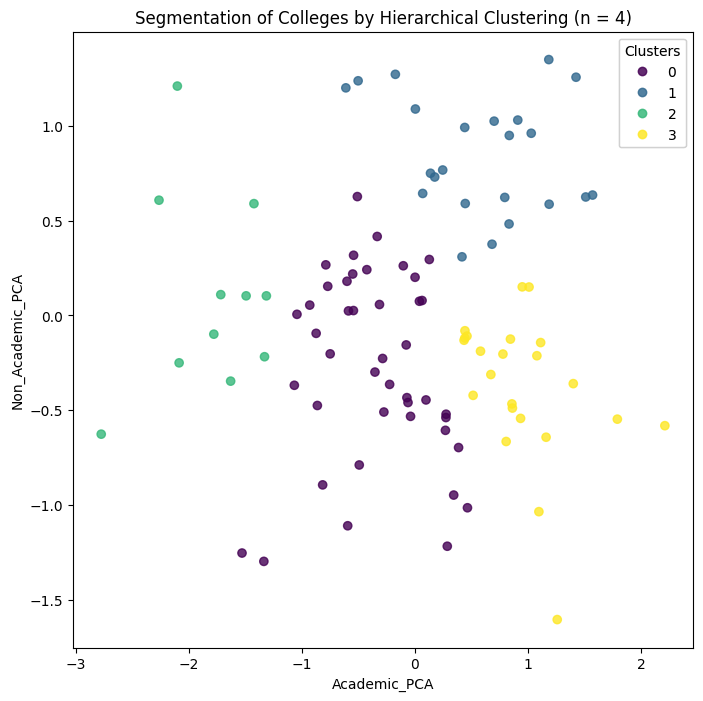

In [ ]:
#Save hierarchical labels as a global variable.
segment_labels = hierarchical_cluster_plot(4, segment_college_data, None, False, param_return=True)

**Segment Column**

In [ ]:
#Assign labels to each College_ID.
college_data['Segment'] = segment_labels

print(college_data['Segment'].value_counts())

Segment
0    43
1    23
3    23
2    11
Name: count, dtype: int64


**Descriptive Labels**

In [ ]:
#Map segment indexes with descriptive labels.
college_data['Segment'] = college_data['Segment'].map({0 : 'Balanced', 1 : 'Prestigious', 2 : 'Vocational', 3 : 'Academic-Focused'})

print(college_data['Segment'].value_counts())

Segment
Balanced            43
Prestigious         23
Academic-Focused    23
Vocational          11
Name: count, dtype: int64


## 6 - **Application of Segments**

- **Aim**
    - Utilise the segments in a way that adds interpretative value to the existing (and future) data.
- **Objectives**
    - Refine the ```Student_Score``` formula based on the distinct characterstics of each segment.
    - Using the newly refined ```Student_Score``` formula - Identify the new thresholds for each type of college.
    - Validate the newly identified thresholds against the current data to determine their predictive accuracy as well as precision and recall.

### 6.1 - Refining the Student Score Formula by Segments

- **Problem Statement**
    - The current ```Student_Score``` formula assumes Academics and Non-Academics holds equal weight in determining a placement for all colleges.
    - However, segmentation reveal natural groupings between colleges present within the data; based on distinctive shared traits.
- **Key Points**
    - Existing ```Student_Score``` determines placements likelihood based on Academics (```Academic_Avg```) and Non-Academics (```IQ``` + ```Projects_Completed``` + ```Internship_Experience```).
    - Academics & Non-Academic weightings currently assumes a **50:50** split between Academics and Non-Academics.
    - Current formula assumes all colleges share the same requirements.

- **Approaches for Formula Refinement**
    - *Mathematical Weightings*
        - Identify Academic & Non-Academic weightings based on mathematical logic. 
            - Axes represents Academic & Non-Academic PCAs.
            - Use midpoints of each segment to derive numerical weightings for their corresponding formula.
        - **Pros**
            - Proven by statistical values.
            - Responds to new data which can improve formula accuracy as time progresses.
            - Formula more accuractely reflects segment structure.
        - **Cons**
            - No explicit midpoints available for Hierarchical Clustering - Manual computation required.
            - Midpoints become dynamic when new data is fed. This causes weightings to become volatile.
            - Risk of overfitting for smaller datasets.
    - *Conceptual Reasoning*
        - Deducing weightings based on human intuition and reasoning.
            - Each segment is distinctively different in a real-world scenario, and each are descriptively labeled.
            - Propose weightings based on distinctive segment traits both from descriptions and visuals.
        - **Pros**
            - Intuitive, interpretable, and easy to communicate.
            - Quick to implement - Less time-consuming.
            - A fixed formula ensures consistency in results.
            - Supports real-world contextual understanding and actionability.
        - **Cons**
            - A fixed formula assumes the world is stagnant - Can be mitigated by updating the formula periodically.
            - Likeliness of lower accuracy & compared to *Mathetical Weightings* - Rational Assumptions VS Mathematical Reasoning.